In [1]:
# ── imports ──────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# generation
from lhcb_velo_toy.generation import (
    PlaneGeometry,
    StateEventGenerator,
)

# solvers
from lhcb_velo_toy.solvers import (
    SimpleHamiltonianFast,
    get_tracks,
)

# analysis
from lhcb_velo_toy.analysis import EventValidator, Match
from lhcb_velo_toy.analysis.plotting.event_display import (
    plot_event_3d,
    plot_reco_vs_truth,
)

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

# ── helper: build geometry from high-level parameters ───────────
def make_geometry(n_modules: int, z_first: float = 100.0, z_spacing: float = 33.0,
                  half_x: float = 50.0, half_y: float = 50.0) -> PlaneGeometry:
    """Create a PlaneGeometry with evenly spaced modules."""
    z_positions = [z_first + i * z_spacing for i in range(n_modules)]
    return PlaneGeometry(
        module_id=list(range(n_modules)),
        lx=[half_x] * n_modules,
        ly=[half_y] * n_modules,
        z=z_positions,
    )

# ── helper: generate a complete event ───────────────────────────
def generate_event(geo, n_tracks, measurement_error=0.0, collision_noise=1e-8,
                   phi_max=0.2, theta_max=0.2):
    """Generate a full event end-to-end."""
    gen = StateEventGenerator(
        detector_geometry=geo,
        events=1,
        n_particles=[n_tracks],
        phi_min=-phi_max, phi_max=phi_max,
        theta_min=-theta_max, theta_max=theta_max,
        measurement_error=measurement_error,
        collision_noise=collision_noise,
    )
    gen.generate_random_primary_vertices({"x": 0.1, "y": 0.1, "z": 50.0})
    particles = [[{"type": "pion", "mass": 139.6, "q": 1}] * n_tracks]
    gen.generate_particles(particles)
    event = gen.generate_complete_events()
    return gen, event

# ── helper: compute epsilon from physics parameters ─────────────
def compute_epsilon(sigma_res, sigma_scatt, dz, scale=1.0, theta_min=1.5e-5):
    """Compute angular acceptance threshold epsilon.

    Uses the paper formula with weighting factors:
        ε = scale × √(2·θ_s² + 12·θ_r² + 2·θ_min²)

    Parameters
    ----------
    sigma_res : float
        Measurement resolution (same units as dz, e.g. mm).
    sigma_scatt : float
        Multiple scattering angle (radians).
    dz : float
        Module spacing (same units as sigma_res).
    scale : float
        Number of sigma to accept (default 1.0).
    theta_min : float
        Minimum threshold to avoid numerical instability (rad).

    Returns
    -------
    float
        Epsilon threshold in radians.
    """
    theta_s = scale * sigma_scatt
    theta_r = np.arctan((scale * sigma_res) / dz) if dz != 0 else 0.0
    return float(np.sqrt(2 * theta_s**2 + 12 * theta_r**2 + 2 * theta_min**2))

print("All imports successful.")


All imports successful.


In [2]:
# ── generate a clean event ──────────────────────────────────────
# 5 modules, 33mm spacing (z: 100-232mm), 50mm half-width
# With max slopes ~0.2 rad, tracks travel ~26mm laterally over 132mm in z
# → all tracks stay well within acceptance
N_TRACKS_CLEAN = 3
N_MODULES_CLEAN = 5

geo_clean = make_geometry(N_MODULES_CLEAN, z_spacing=33.0)

# Retry until we get an event where every track has >= 3 hits
# (rare acceptance losses can occur at boundaries)
for attempt in range(20):
    gen_clean, event_clean = generate_event(geo_clean, N_TRACKS_CLEAN)
    min_hits = min(len(t.hit_ids) for t in event_clean.tracks)
    if min_hits >= 3:
        break

print(f"Clean event: {len(event_clean.tracks)} tracks, "
      f"{len(event_clean.hits)} hits across {len(event_clean.modules)} modules")
for trk in event_clean.tracks:
    print(f"  Track {trk.track_id}: {len(trk.hit_ids)} hits")

Clean event: 3 tracks, 15 hits across 5 modules
  Track 0: 5 hits
  Track 1: 5 hits
  Track 2: 5 hits


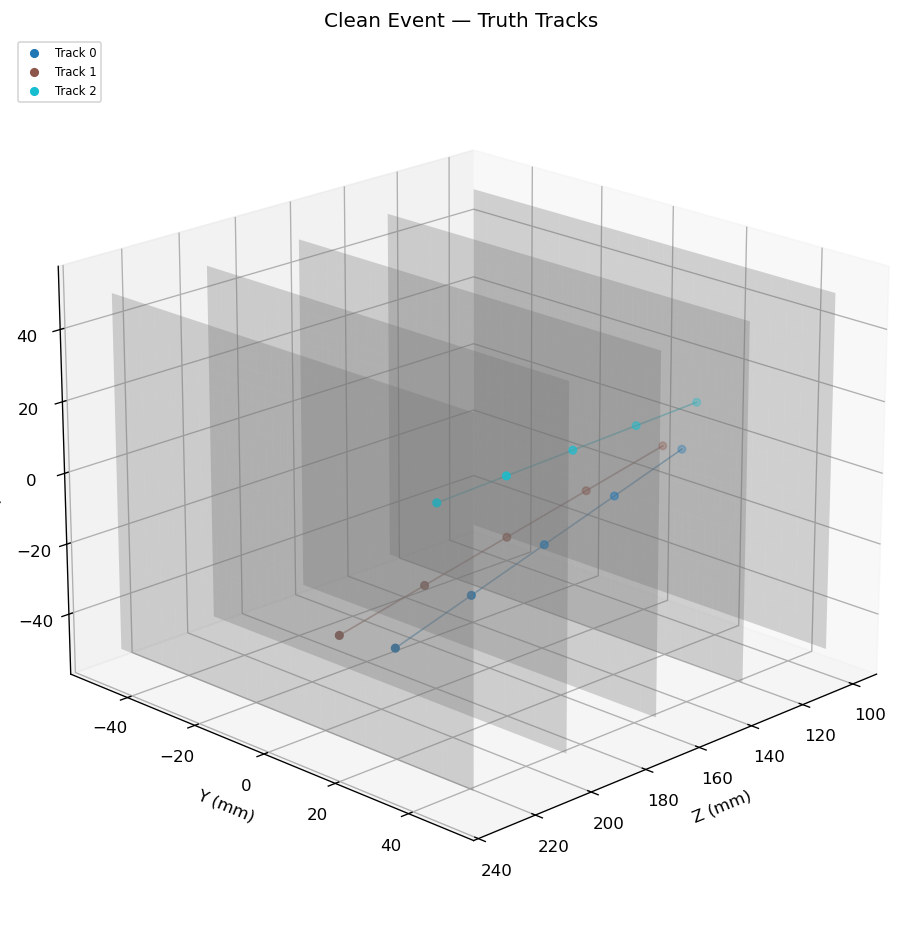

In [3]:
# ── 3-D truth display ───────────────────────────────────────────
fig_truth = plot_event_3d(event_clean, title="Clean Event — Truth Tracks")
plt.show()

In [4]:
# ── build Hamiltonian & solve classically ────────────────────────
# Physics parameters for epsilon computation
SIGMA_RES   = 0.0     # measurement resolution (mm) — 0 for clean event
SIGMA_SCATT = 1e-3    # collision noise (rad) — matches generate_event default
DZ_MM       = 33.0    # module spacing (mm)
SCALE       = 3.0     # accept segment pairs within 3σ

EPSILON = compute_epsilon(SIGMA_RES, SIGMA_SCATT, DZ_MM, scale=SCALE)
GAMMA   = 1.5    # self-interaction penalty
DELTA   = 1.0    # bias weight

print(f"Computed ε = {EPSILON:.6f} rad ({EPSILON*1e3:.3f} mrad)")

ham_clean = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
A_clean, b_clean = ham_clean.construct_hamiltonian(event_clean)
x_clean = ham_clean.solve_classicaly()

# An uncoupled (fake) segment has activation δ/(δ+γ).
# True segments, boosted by collinear couplings, sit above this.
BASELINE = DELTA / (DELTA + GAMMA)
THRESHOLD = (1 + BASELINE) / 2          # midpoint → clear separator

print(f"Segments:  {ham_clean.n_segments}")
print(f"Matrix A:  {A_clean.shape[0]}×{A_clean.shape[1]}, nnz={A_clean.nnz}")
print(f"Uncoupled baseline:  x ≈ {BASELINE:.3f}")
print(f"Threshold:           {THRESHOLD:.3f}")
print(f"Active (above thr):  {np.sum(x_clean > THRESHOLD)} / {len(x_clean)} segments")
print(f"Min / Max activation: {x_clean.min():.4f} / {x_clean.max():.4f}")


Computed ε = 0.004243 rad (4.243 mrad)
Segments:  36
Matrix A:  36×36, nnz=54
Uncoupled baseline:  x ≈ 0.400
Threshold:           0.700
Active (above thr):  12 / 36 segments
Min / Max activation: 0.4000 / 1.2727


In [5]:
# ── reconstruct tracks ──────────────────────────────────────────
reco_clean = get_tracks(ham_clean, x_clean, event_clean, threshold=THRESHOLD)
print(f"Reconstructed {len(reco_clean)} tracks")
for trk in reco_clean:
    print(f"  Reco track {trk.track_id}: {len(trk.hit_ids)} hits")

Reconstructed 3 tracks
  Reco track 0: 5 hits
  Reco track 1: 5 hits
  Reco track 2: 5 hits


In [6]:
event_clean

Event(detector_geometry=PlaneGeometry(module_id=[0, 1, 2, 3, 4], lx=[50.0, 50.0, 50.0, 50.0, 50.0], ly=[50.0, 50.0, 50.0, 50.0, 50.0], z=[100.0, 133.0, 166.0, 199.0, 232.0]), primary_vertices=[PrimaryVertex(pv_id=0, x=0.019900923060882734, y=-0.05815551880424294, z=30.41039083643326, track_ids=[0, 1, 2], extra={})], tracks=[Track(track_id=0, pv_id=0, hit_ids=[0, 1, 2, 3, 4], extra={}), Track(track_id=1, pv_id=0, hit_ids=[5, 6, 7, 8, 9], extra={}), Track(track_id=2, pv_id=0, hit_ids=[10, 11, 12, 13, 14], extra={})], hits=[Hit(hit_id=0, x=np.float64(-6.729315205545025), y=np.float64(10.027170208660701), z=100.0, module_id=0, track_id=0, extra={}), Hit(hit_id=1, x=np.float64(-9.929852516109996), y=np.float64(14.809719521772468), z=133.0, module_id=1, track_id=0, extra={}), Hit(hit_id=2, x=np.float64(-13.13039025493901), y=np.float64(19.592268699653005), z=166.0, module_id=2, track_id=0, extra={}), Hit(hit_id=3, x=np.float64(-16.330928179487874), y=np.float64(24.374818057477704), z=199.0, 

In [7]:
type(reco_clean[0])

lhcb_velo_toy.generation.entities.track.Track

In [8]:
reco_hits = [hit_id for trk in reco_clean for hit_id in trk.hit_ids]

In [9]:
from lhcb_velo_toy.solvers.reconstruction import construct_event

In [10]:
# Extract Hit objects corresponding to the reconstructed hit IDs
reco_hit_objects = [hit for hit in event_clean.hits if hit.hit_id in reco_hits]

event_reco = construct_event(
    detector_geometry=geo_clean,
    tracks=reco_clean,
    hits=reco_hit_objects
)

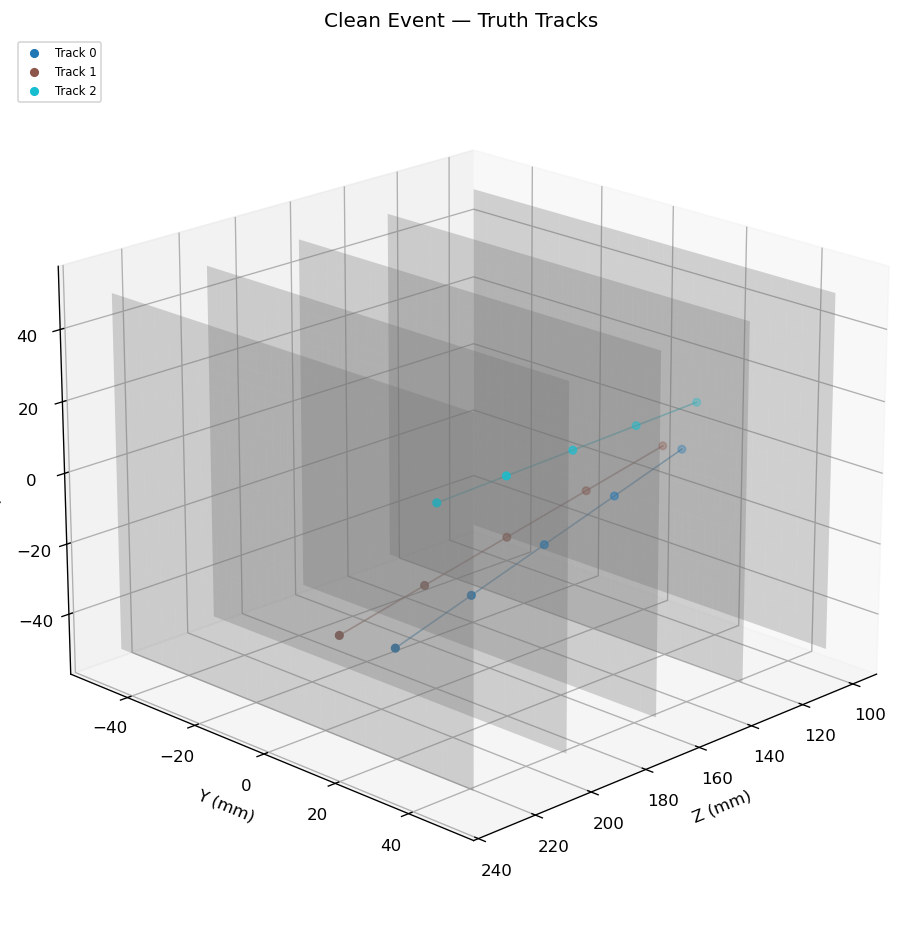

In [11]:
# ── 3-D truth display ───────────────────────────────────────────
fig_truth = plot_event_3d(event_clean, title="Clean Event — Truth Tracks")
plt.show()

In [12]:
# ── validate: match reco → truth ────────────────────────────────
val_clean = EventValidator(event_clean, reco_clean)
matches_clean, metrics_clean = val_clean.match_tracks(purity_min=0.7)

print("=== Clean Event Metrics ===")
for k, v in metrics_clean.items():
    print(f"  {k:25s}: {v}")

# per-track detail
print("\nPer-track matches:")
print(f"  {'Truth':>6}  {'RecHits':>7}  {'Purity':>7}  {'HitEff':>7}  {'Type'}")
for m in matches_clean:
    label = "PRIMARY" if m.is_primary else ("GHOST" if m.is_ghost else "CLONE")
    truth_str = str(m.truth_id) if m.truth_id is not None else "-"
    print(f"  {truth_str:>6}  {m.rec_hits:7d}  "
          f"{m.purity:7.3f}  {m.hit_efficiency:7.3f}  {label}")

=== Clean Event Metrics ===
  efficiency               : 1.0
  ghost_rate               : 0.0
  clone_fraction           : 0.0
  mean_purity              : 1.0
  hit_efficiency           : 1.0
  n_candidates             : 3
  n_accepted               : 3
  n_ghosts                 : 0
  n_clones                 : 0
  n_primary                : 3
  n_reconstructible        : 3
  n_matched                : 3

Per-track matches:
   Truth  RecHits   Purity   HitEff  Type
       0        5    1.000    1.000  PRIMARY
       1        5    1.000    1.000  PRIMARY
       2        5    1.000    1.000  PRIMARY



=== Generating Event 0 with 2 tracks ===
  Event 0: 2 tracks, 10 hits
  Reconstructed 2 tracks


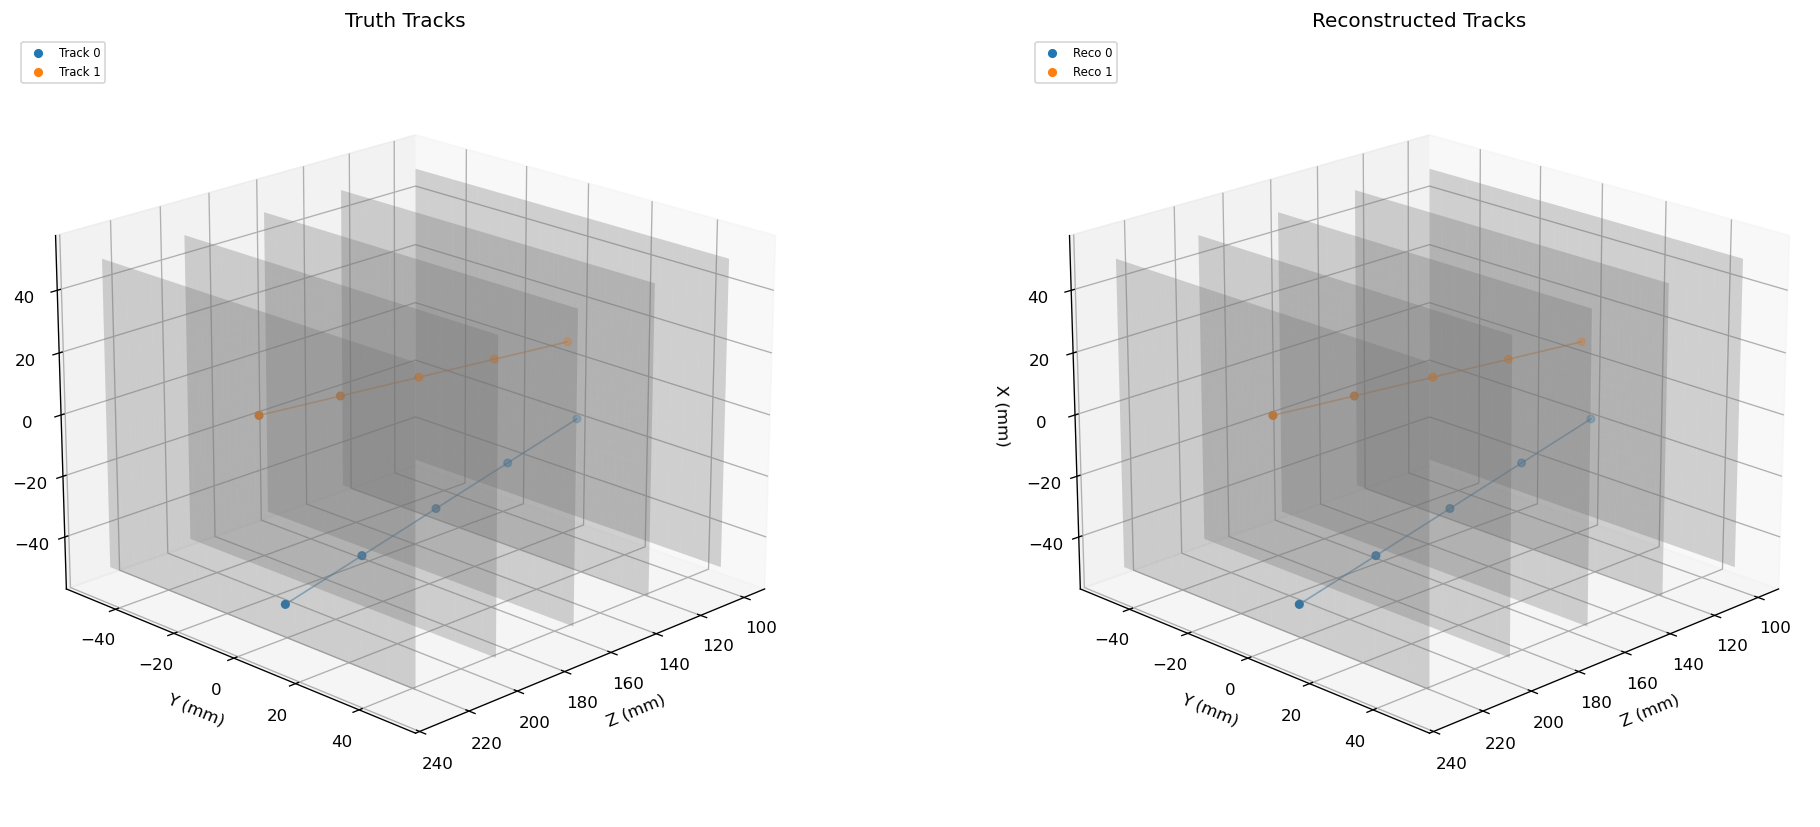


=== Generating Event 1 with 3 tracks ===
  Event 1: 3 tracks, 15 hits
  Reconstructed 3 tracks


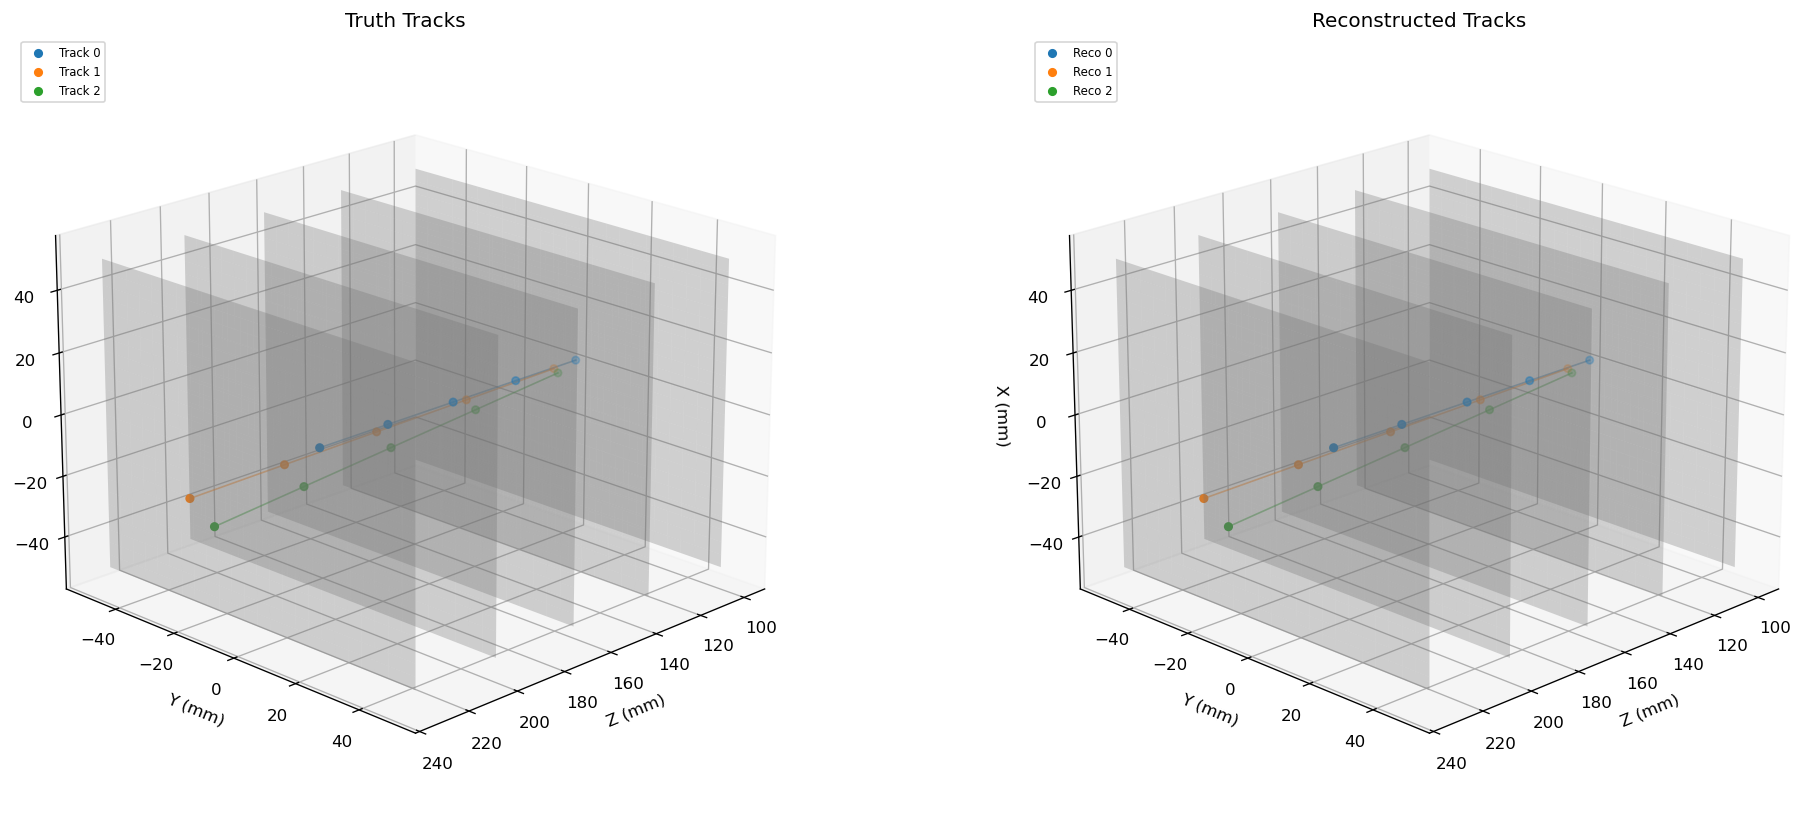


=== Generating Event 2 with 4 tracks ===
  Event 2: 4 tracks, 20 hits
  Reconstructed 4 tracks


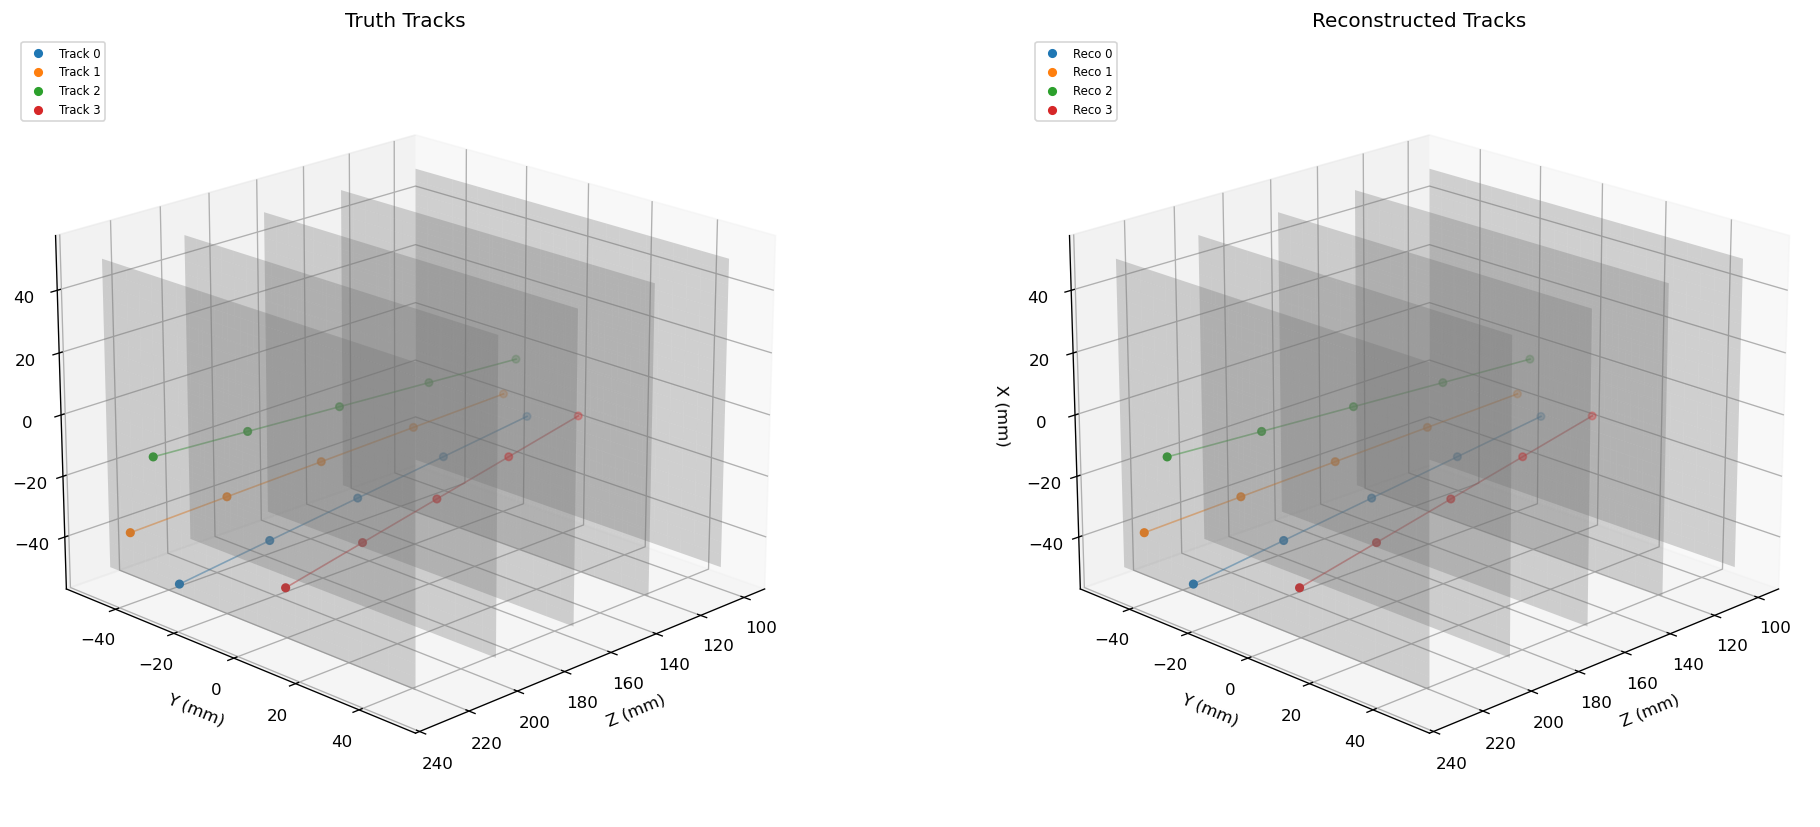


=== Generating Event 3 with 5 tracks ===
  Event 3: 5 tracks, 25 hits
  Reconstructed 5 tracks


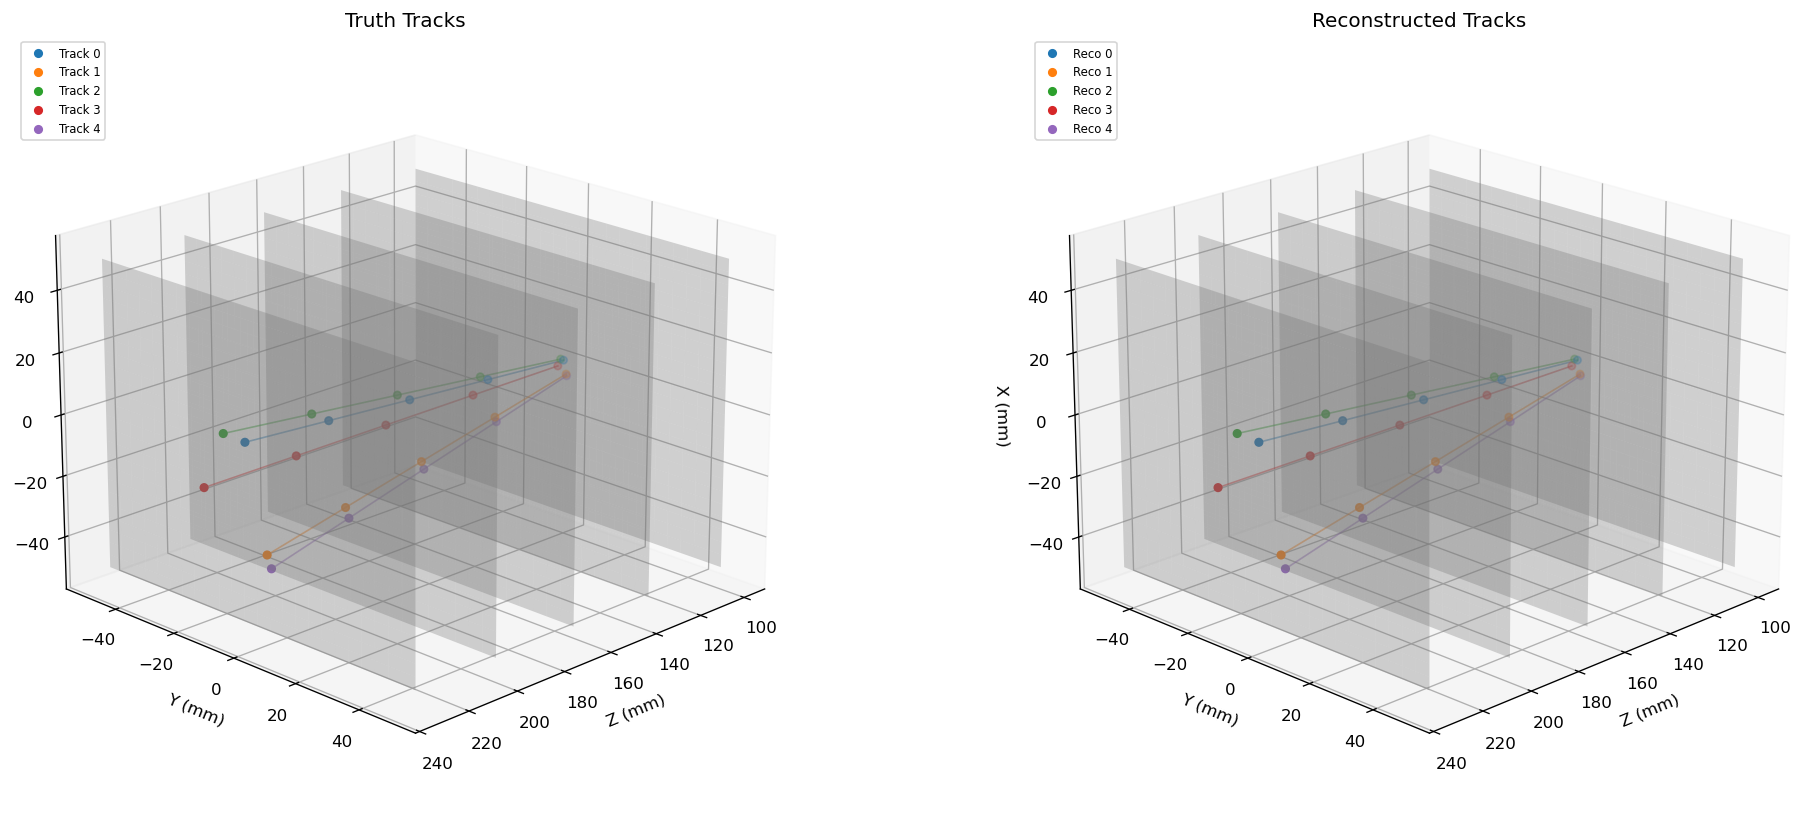


=== Generating Event 4 with 6 tracks ===
  Event 4: 6 tracks, 22 hits
  Reconstructed 2 tracks


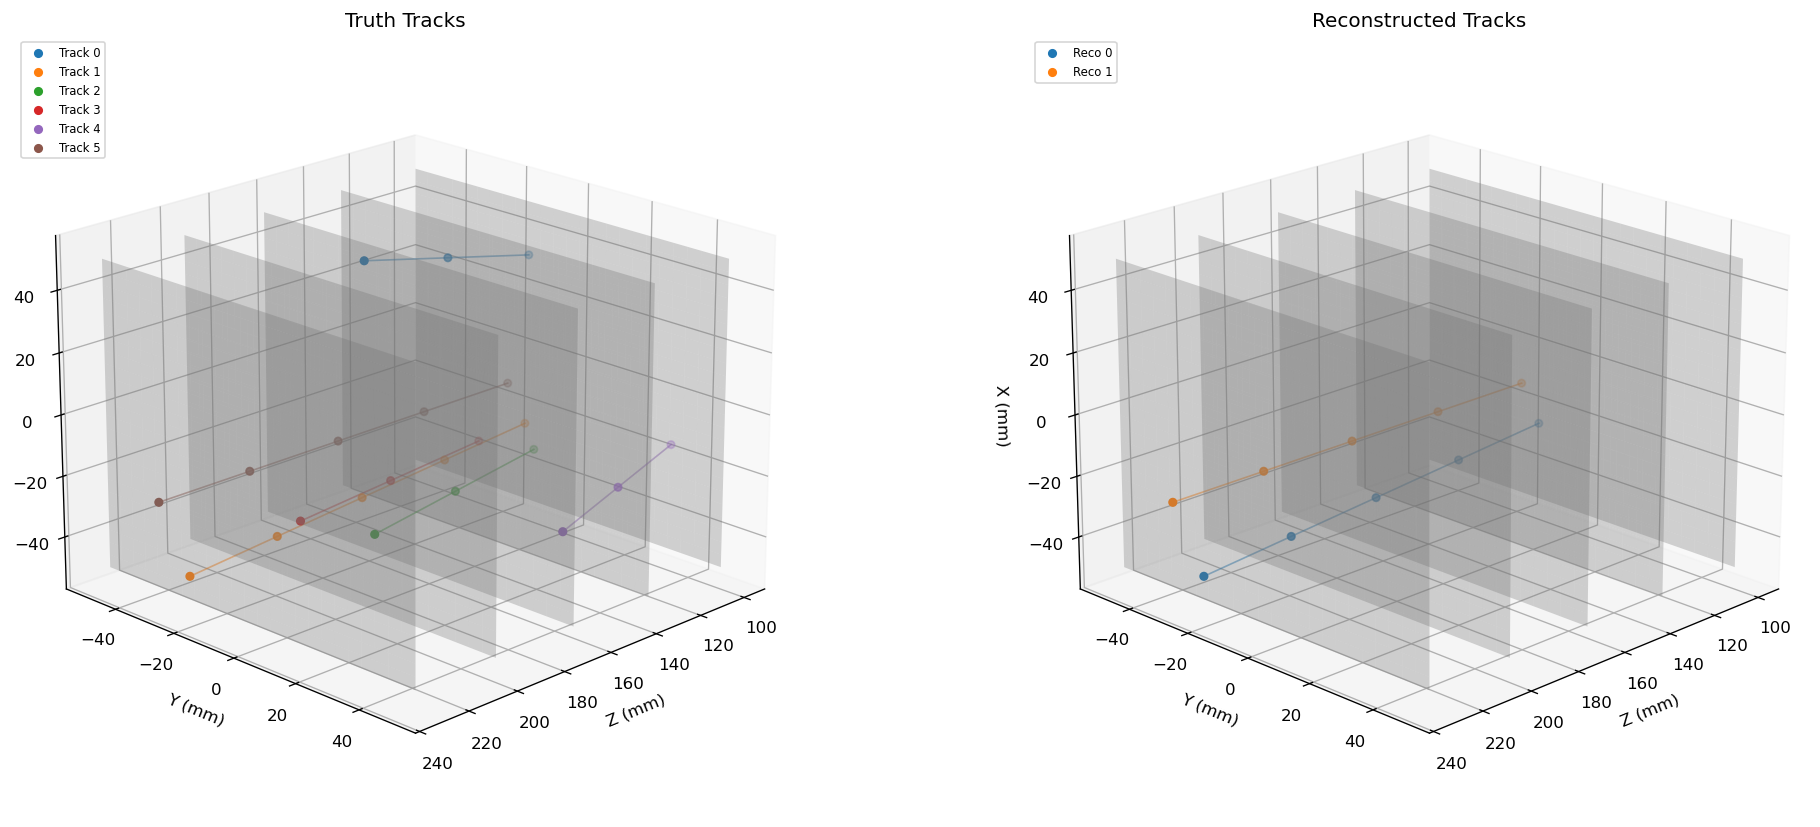


=== Generating Event 5 with 3 tracks ===
  Event 5: 3 tracks, 15 hits
  Reconstructed 3 tracks


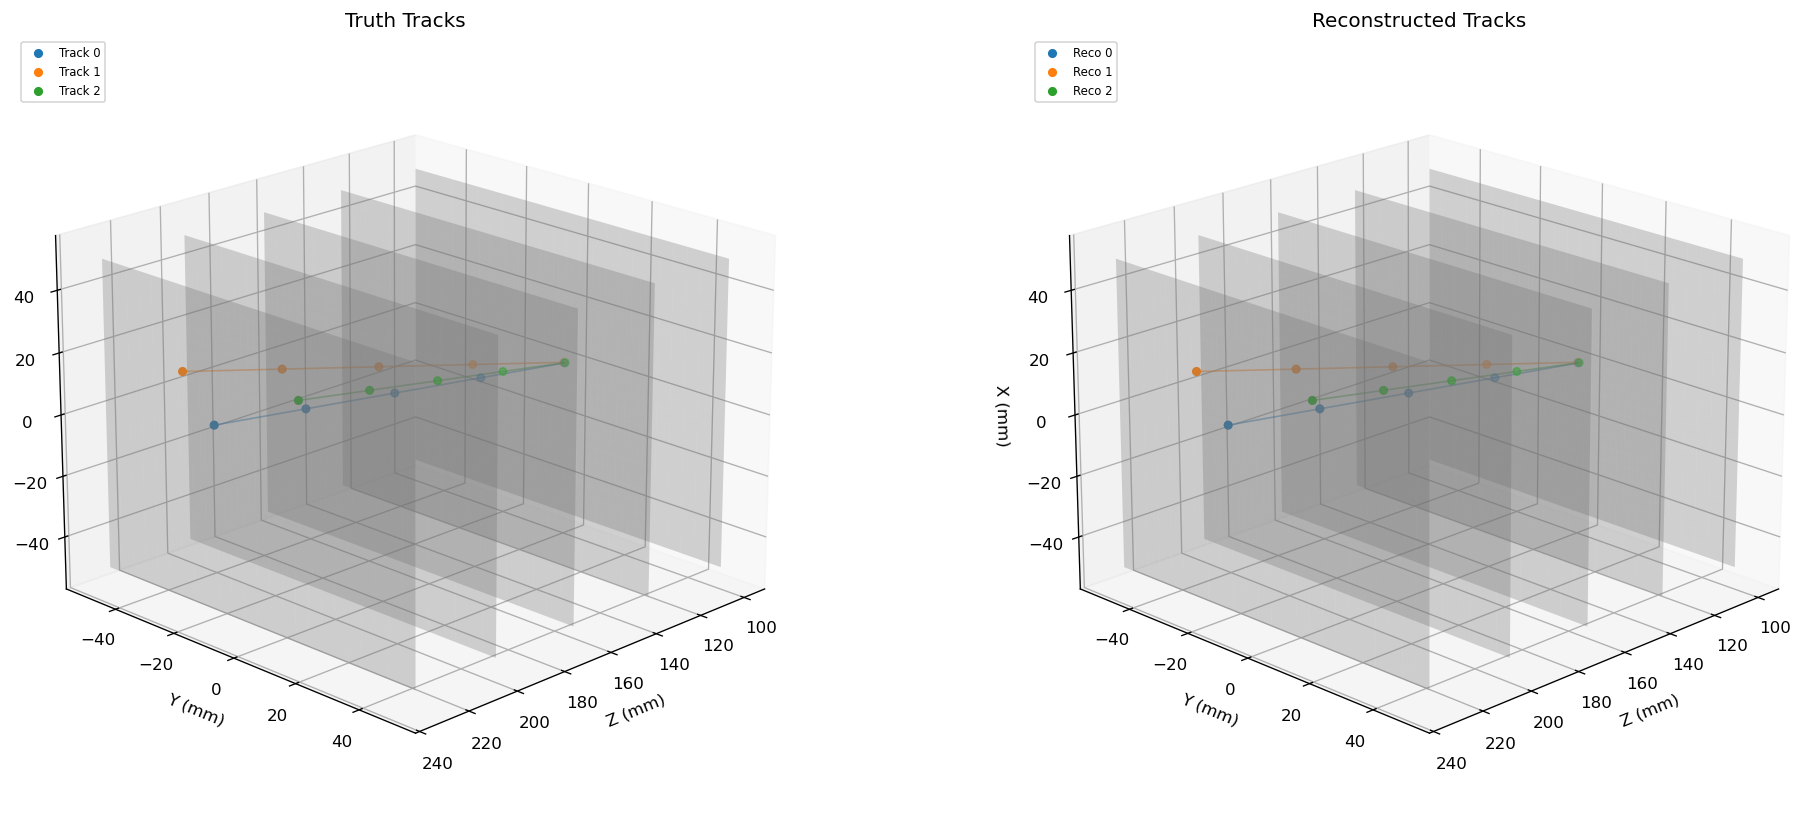


=== Generating Event 6 with 4 tracks ===
  Event 6: 4 tracks, 20 hits
  Reconstructed 3 tracks


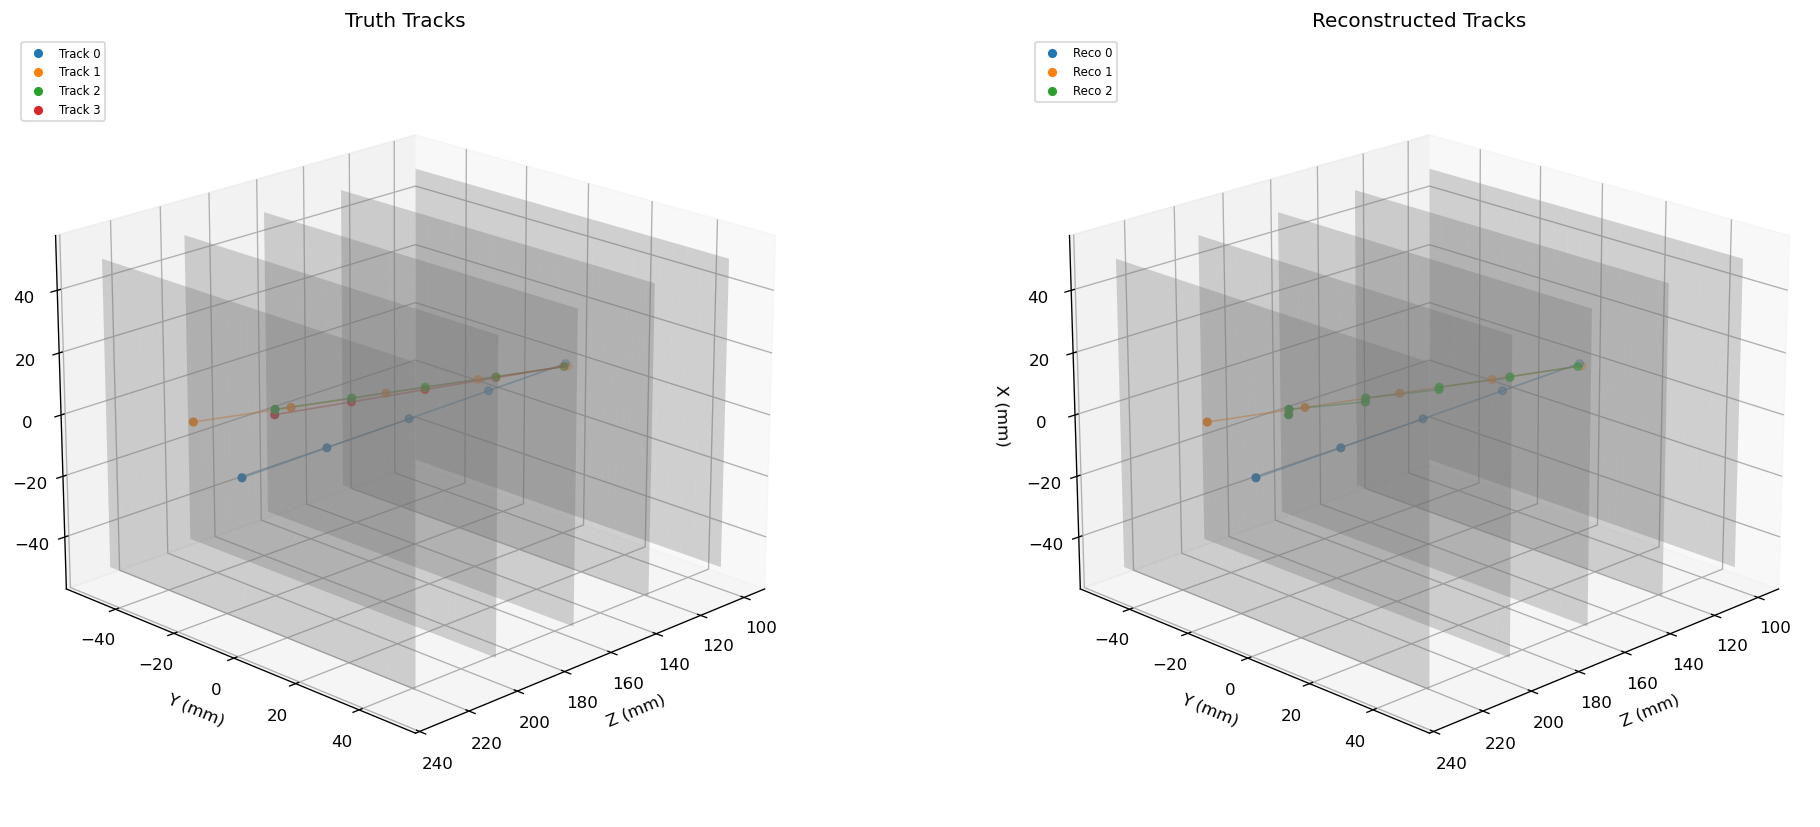


=== Generating Event 7 with 5 tracks ===
  Event 7: 5 tracks, 25 hits
  Reconstructed 5 tracks


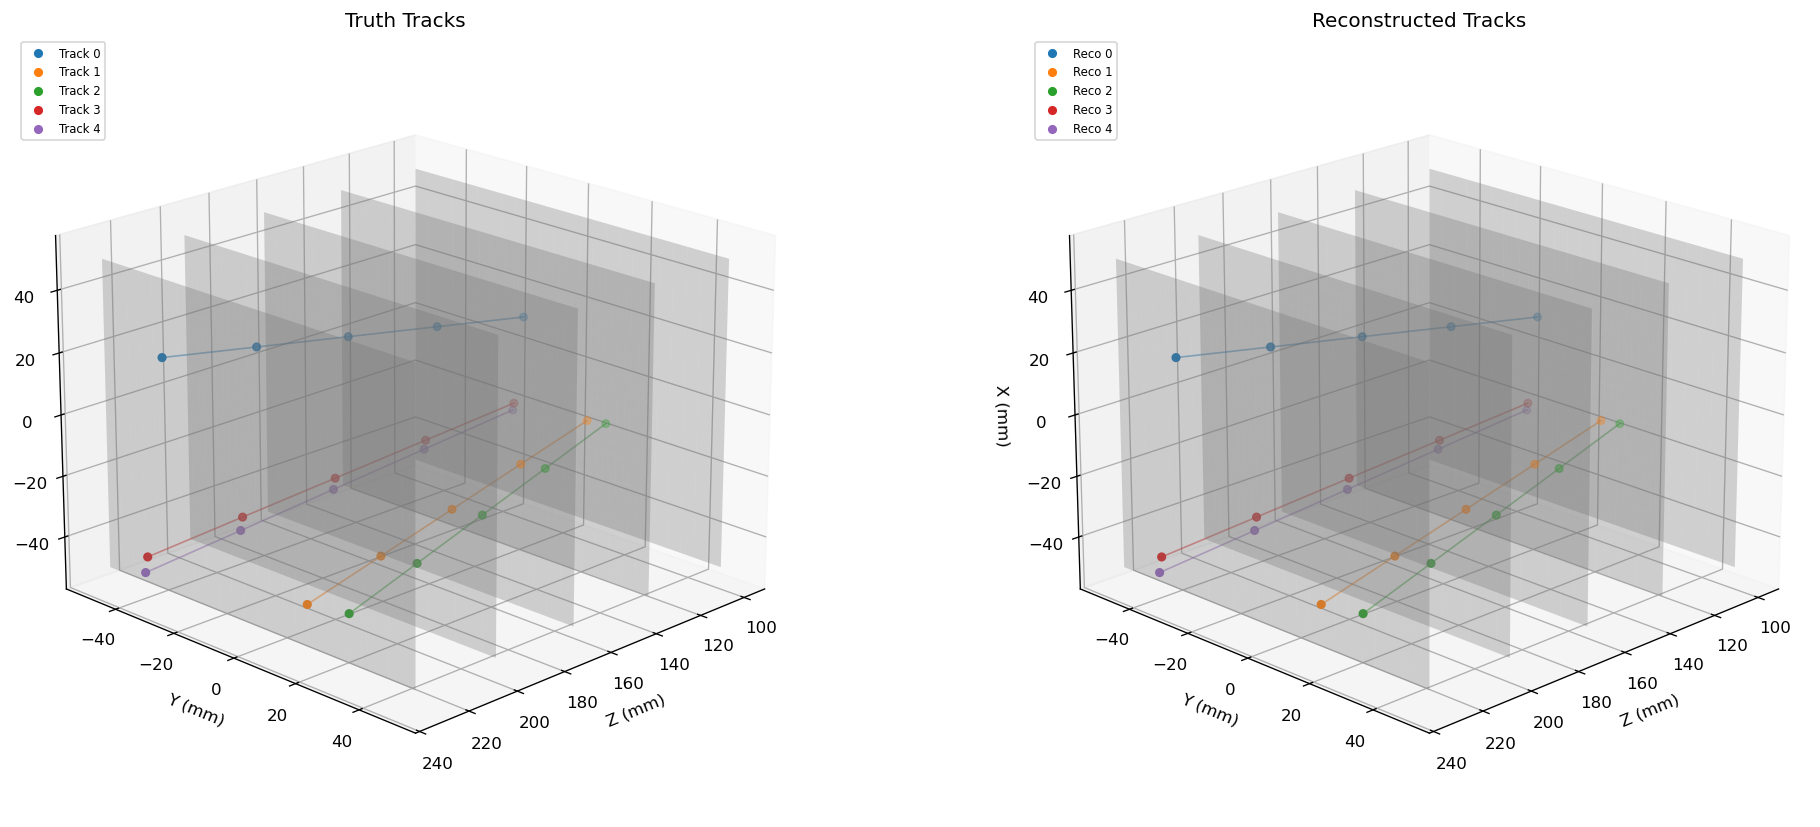


=== Generating Event 8 with 2 tracks ===
  Event 8: 2 tracks, 10 hits
  Reconstructed 2 tracks


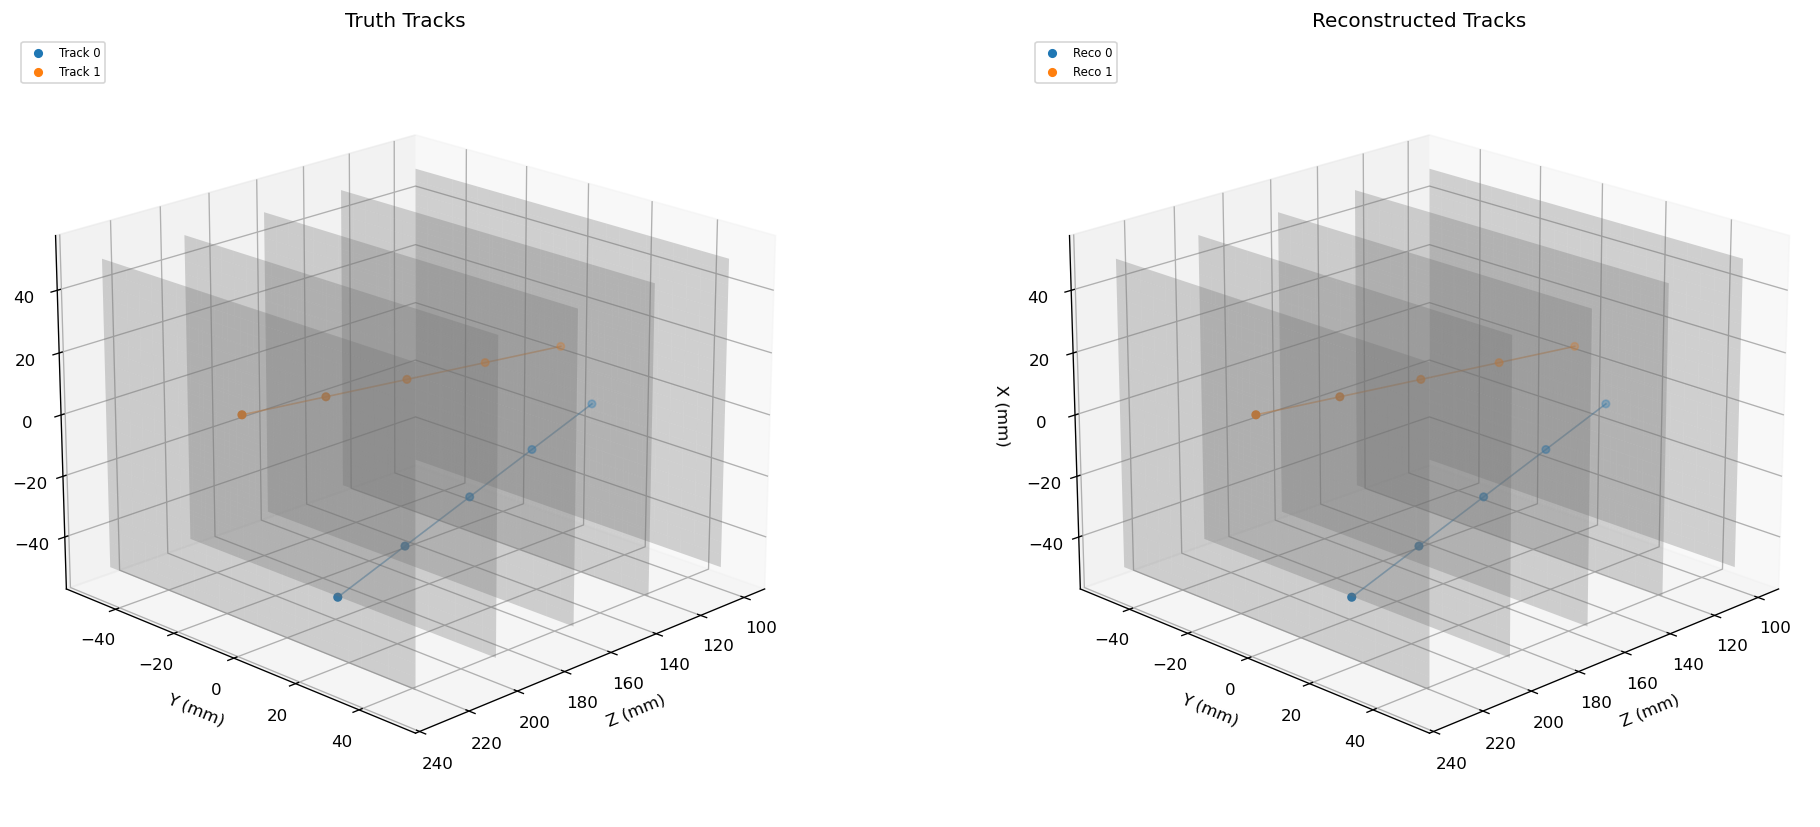


=== Generating Event 9 with 4 tracks ===
  Event 9: 4 tracks, 20 hits
  Reconstructed 4 tracks


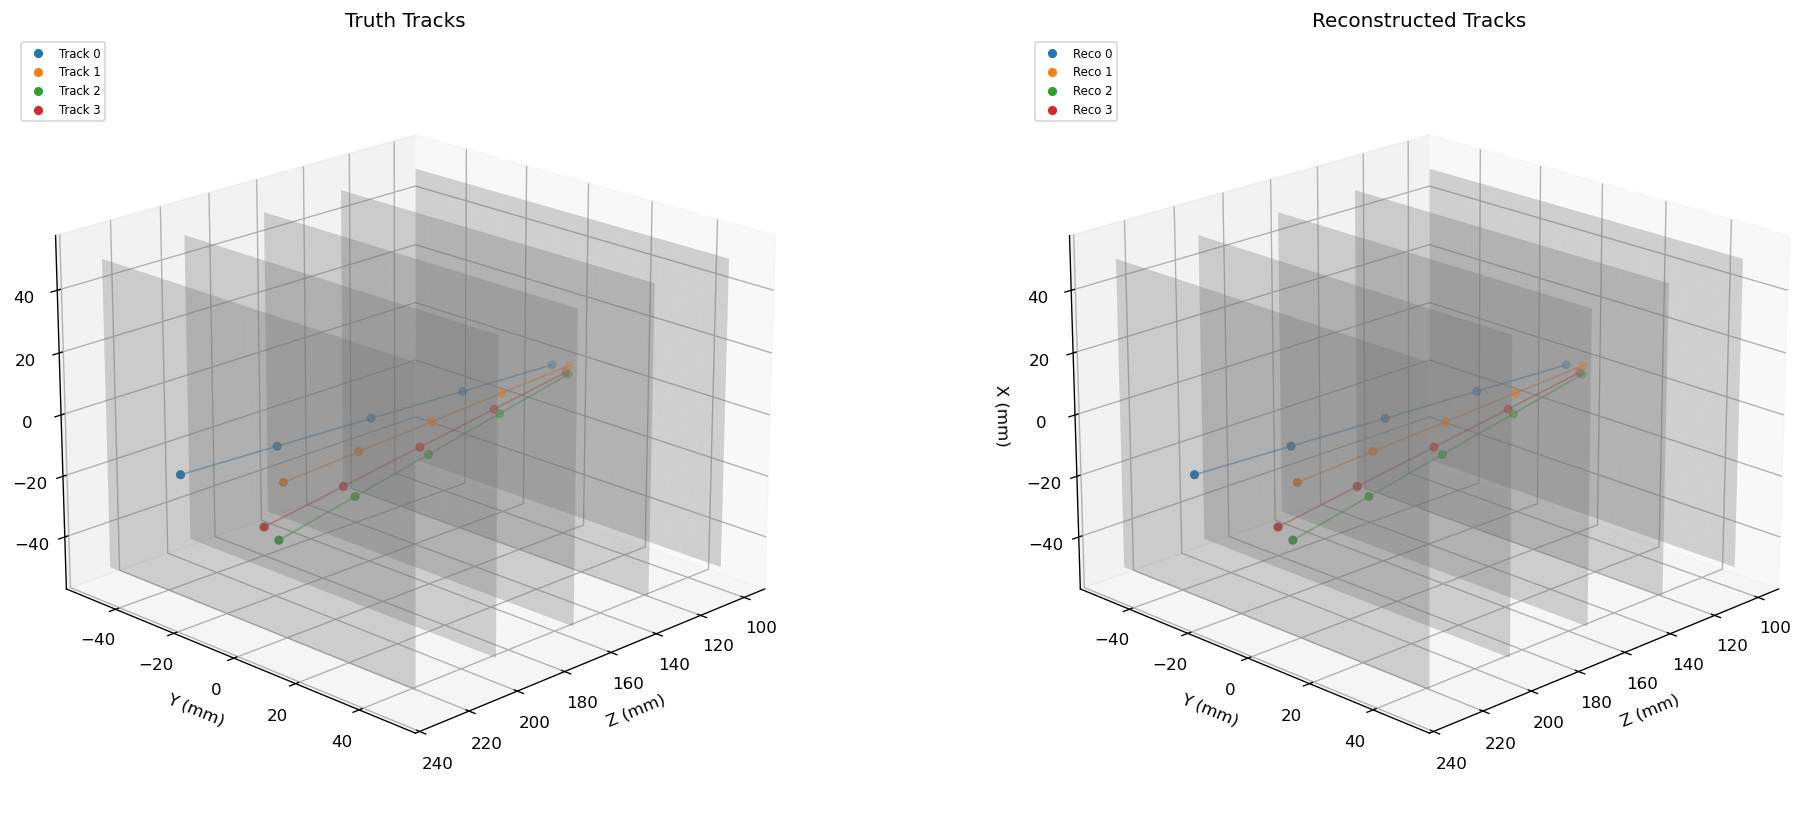


=== Summary ===
 Event   True   Reco     Eff   Ghost   TrueSeg   RecoSeg
     0      2      2   1.000   0.000         8         8
     1      3      3   1.000   0.000        12        12
     2      4      4   1.000   0.000        16        16
     3      5      5   1.000   0.000        20        20
     4      6      2   0.333   0.000        16         8
     5      3      3   1.000   0.000        12        12
     6      4      3   0.500   0.333        16        17
     7      5      5   1.000   0.000        20        20
     8      2      2   1.000   0.000         8         8
     9      4      4   1.000   0.000        16        16


In [13]:
import random

# ── generate 10 events with varying track counts ────────────────

# Track counts from 2 to 6 for variety
track_counts = [2, 3, 4, 5, 6, 3, 4, 5, 2, 4]
events_data = []

for i, n_tracks in enumerate(track_counts):
    print(f"\n=== Generating Event {i} with {n_tracks} tracks ===")
    
    # Generate event with retry logic for acceptance
    for attempt in range(20):
        gen, event = generate_event(geo_clean, n_tracks)
        min_hits = min(len(t.hit_ids) for t in event.tracks)
        if min_hits >= 3:
            break
    
    print(f"  Event {i}: {len(event.tracks)} tracks, {len(event.hits)} hits")
    
    # Build Hamiltonian and solve
    ham = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
    A, b = ham.construct_hamiltonian(event)
    x = ham.solve_classicaly()
    
    # Reconstruct tracks
    reco_tracks = get_tracks(ham, x, event, threshold=THRESHOLD)
    print(f"  Reconstructed {len(reco_tracks)} tracks")
    
    # Extract segments (true and reconstructed)
    true_segments = []
    for track in event.tracks:
        hit_ids = track.hit_ids
        for j in range(len(hit_ids) - 1):
            true_segments.append((hit_ids[j], hit_ids[j+1]))
    
    reco_segments = []
    for track in reco_tracks:
        hit_ids = track.hit_ids
        for j in range(len(hit_ids) - 1):
            reco_segments.append((hit_ids[j], hit_ids[j+1]))
    
    # Validate
    val = EventValidator(event, reco_tracks)
    matches, metrics = val.match_tracks(purity_min=0.7)
    
    # Store data
    events_data.append({
        'event_id': i,
        'n_tracks_true': len(event.tracks),
        'n_tracks_reco': len(reco_tracks),
        'event': event,
        'reco_tracks': reco_tracks,
        'true_segments': true_segments,
        'reco_segments': reco_segments,
        'matches': matches,
        'metrics': metrics,
        'ham': ham,
        'x': x
    })
    
    # Plot truth vs reco
    fig = plot_reco_vs_truth(event, reco_tracks)
    plt.show()

print("\n=== Summary ===")
print(f"{'Event':>6}  {'True':>5}  {'Reco':>5}  {'Eff':>6}  {'Ghost':>6}  {'TrueSeg':>8}  {'RecoSeg':>8}")
for ed in events_data:
    print(f"{ed['event_id']:6d}  {ed['n_tracks_true']:5d}  {ed['n_tracks_reco']:5d}  "
          f"{ed['metrics']['efficiency']:6.3f}  {ed['metrics']['ghost_rate']:6.3f}  "
          f"{len(ed['true_segments']):8d}  {len(ed['reco_segments']):8d}")

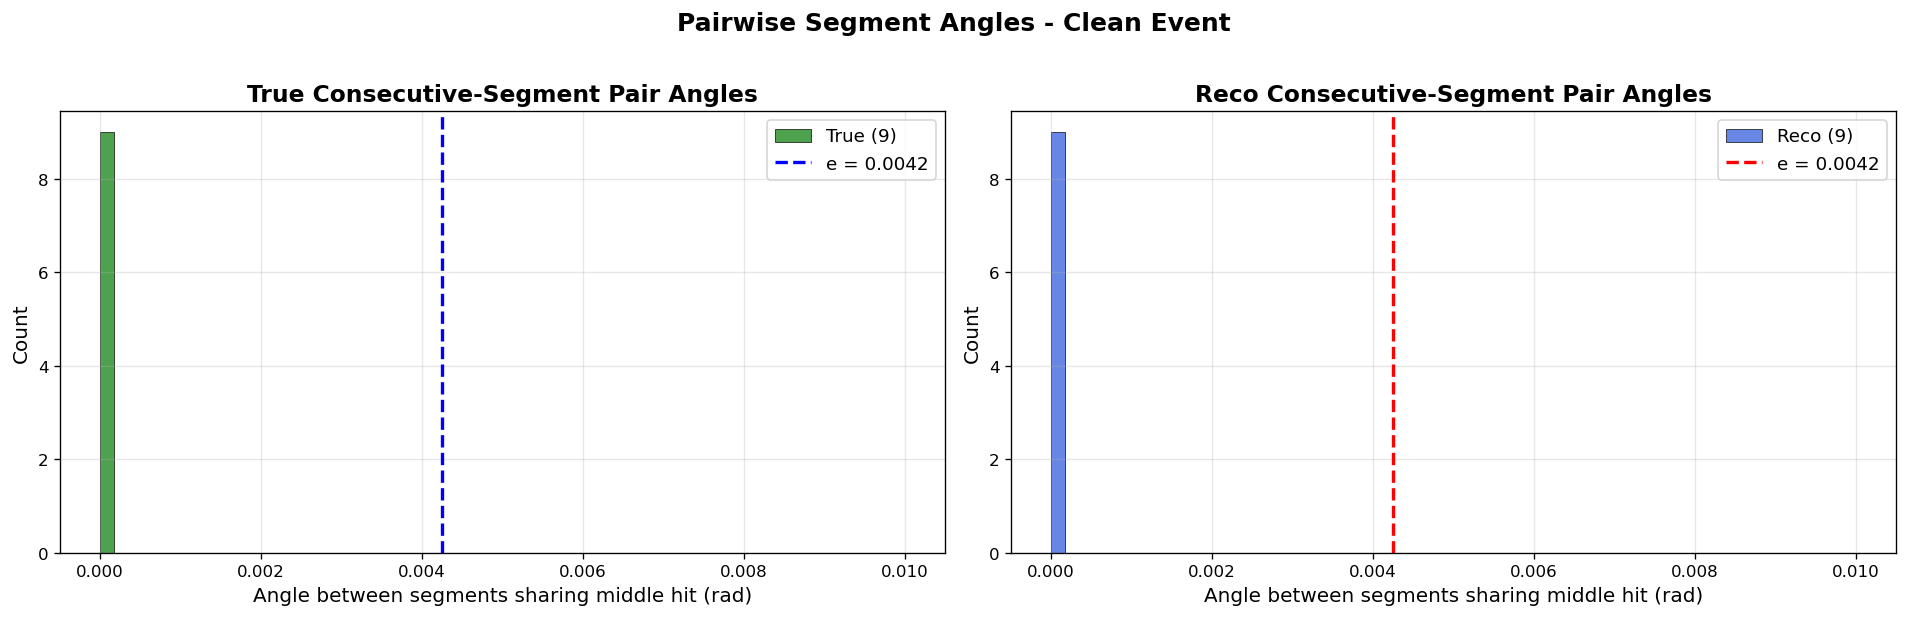

True pairs: 9, mean = 0.000000 rad (0.000 mrad)
Reco pairs: 9, mean = 0.000000 rad (0.000 mrad)
epsilon = 0.004243 rad (4.243 mrad)


In [14]:
# ── Pairwise segment angles (shared middle hit) — Clean Event ────
# The Hamiltonian checks the angle BETWEEN consecutive segments
# sharing a middle hit, not the angle w.r.t. the beam.

hits_dict_clean = {hit.hit_id: hit for hit in event_clean.hits}

def pairwise_angle(h_a, h_b, h_c, hd):
    """Angle between segment (a->b) and (b->c) sharing middle hit b."""
    ha, hb, hc = hd[h_a], hd[h_b], hd[h_c]
    v1 = np.array([hb.x - ha.x, hb.y - ha.y, hb.z - ha.z])
    v2 = np.array([hc.x - hb.x, hc.y - hb.y, hc.z - hb.z])
    cos_a = np.clip(
        np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)),
        -1.0, 1.0)
    return np.arccos(cos_a)

def pairwise_angles_from_tracks(tracks, hd):
    """Angles between consecutive segment pairs on each track."""
    angles = []
    for trk in tracks:
        hids = trk.hit_ids
        for k in range(len(hids) - 2):
            angles.append(pairwise_angle(hids[k], hids[k+1], hids[k+2], hd))
    return np.array(angles) if angles else np.array([])

true_seg_angles_clean = pairwise_angles_from_tracks(event_clean.tracks, hits_dict_clean)
reco_seg_angles_clean = pairwise_angles_from_tracks(reco_clean, hits_dict_clean)

# Plot
hi = max(0.01, max(true_seg_angles_clean.max(), reco_seg_angles_clean.max()) * 1.5) if len(true_seg_angles_clean) else 0.01
bins = np.linspace(0, hi, 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(true_seg_angles_clean, bins=bins, color='forestgreen', alpha=0.8,
             edgecolor='black', lw=0.5, label=f'True ({len(true_seg_angles_clean)})')
axes[0].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'e = {EPSILON:.4f}')
axes[0].set_title('True Consecutive-Segment Pair Angles', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Angle between segments sharing middle hit (rad)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].hist(reco_seg_angles_clean, bins=bins, color='royalblue', alpha=0.8,
             edgecolor='black', lw=0.5, label=f'Reco ({len(reco_seg_angles_clean)})')
axes[1].axvline(EPSILON, color='red', ls='--', lw=2, label=f'e = {EPSILON:.4f}')
axes[1].set_title('Reco Consecutive-Segment Pair Angles', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Angle between segments sharing middle hit (rad)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.suptitle('Pairwise Segment Angles - Clean Event', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"True pairs: {len(true_seg_angles_clean)}, mean = {true_seg_angles_clean.mean():.6f} rad ({true_seg_angles_clean.mean()*1e3:.3f} mrad)")
print(f"Reco pairs: {len(reco_seg_angles_clean)}, mean = {reco_seg_angles_clean.mean():.6f} rad ({reco_seg_angles_clean.mean()*1e3:.3f} mrad)")
print(f"epsilon = {EPSILON:.6f} rad ({EPSILON*1e3:.3f} mrad)")

In [15]:
events_data


[{'event_id': 0,
  'n_tracks_true': 2,
  'n_tracks_reco': 2,
  'event': Event(detector_geometry=PlaneGeometry(module_id=[0, 1, 2, 3, 4], lx=[50.0, 50.0, 50.0, 50.0, 50.0], ly=[50.0, 50.0, 50.0, 50.0, 50.0], z=[100.0, 133.0, 166.0, 199.0, 232.0]), primary_vertices=[PrimaryVertex(pv_id=0, x=-0.06015169034540513, y=0.13958556305524525, z=-1.292739811330924, track_ids=[0, 1], extra={})], tracks=[Track(track_id=0, pv_id=0, hit_ids=[0, 1, 2, 3, 4], extra={}), Track(track_id=1, pv_id=0, hit_ids=[5, 6, 7, 8, 9], extra={})], hits=[Hit(hit_id=0, x=np.float64(-17.0702347222282), y=np.float64(4.076514152031826), z=100.0, module_id=0, track_id=0, extra={}), Hit(hit_id=1, x=np.float64(-22.61192268459903), y=np.float64(5.35911954045055), z=133.0, module_id=1, track_id=0, extra={}), Hit(hit_id=2, x=np.float64(-28.153610570165164), y=np.float64(6.641725052236647), z=166.0, module_id=2, track_id=0, extra={}), Hit(hit_id=3, x=np.float64(-33.695298437291264), y=np.float64(7.924330659007378), z=199.0, modu

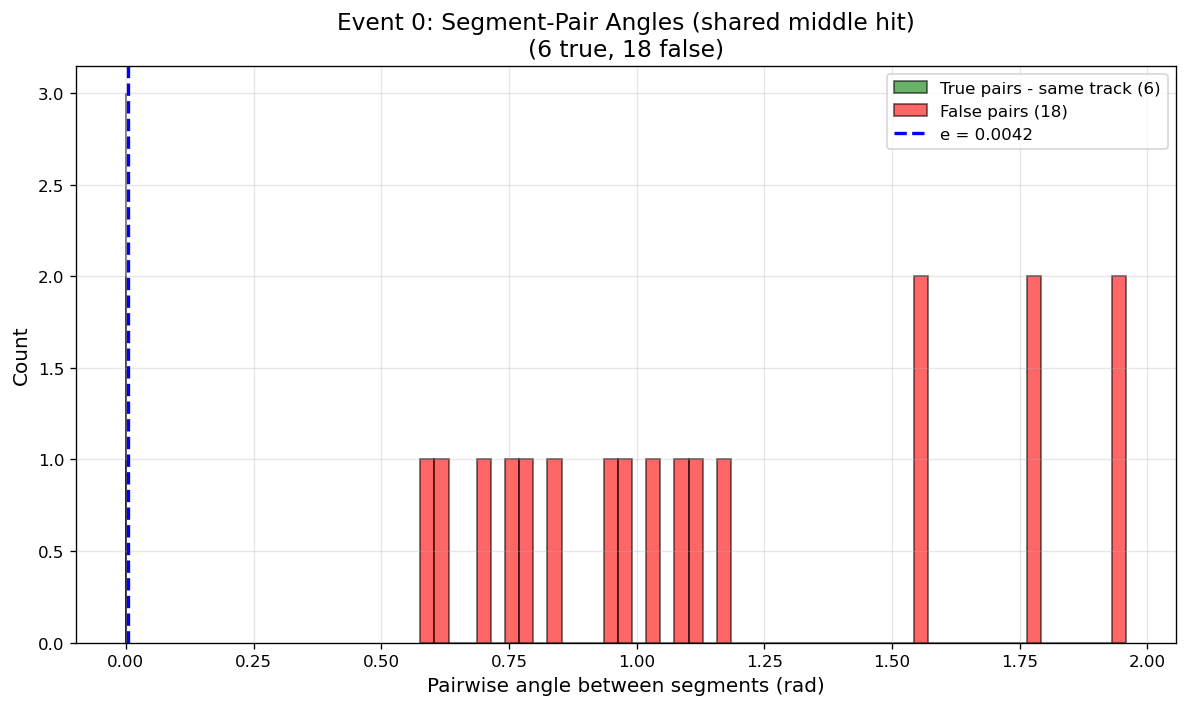

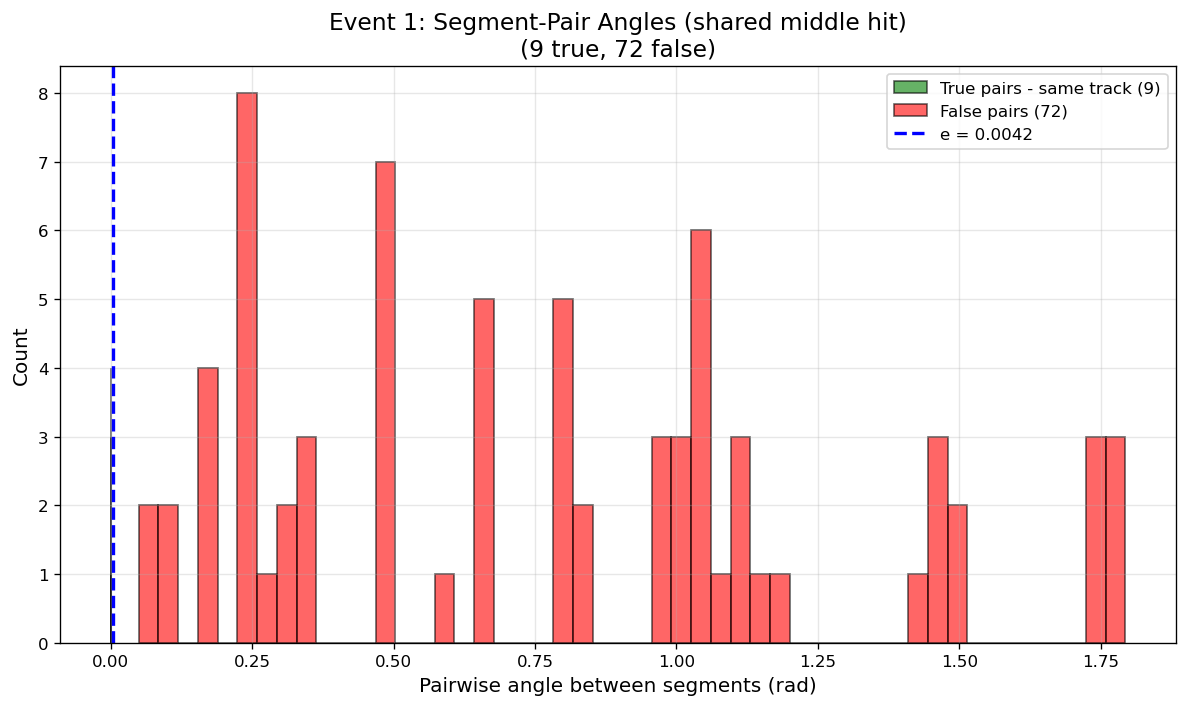

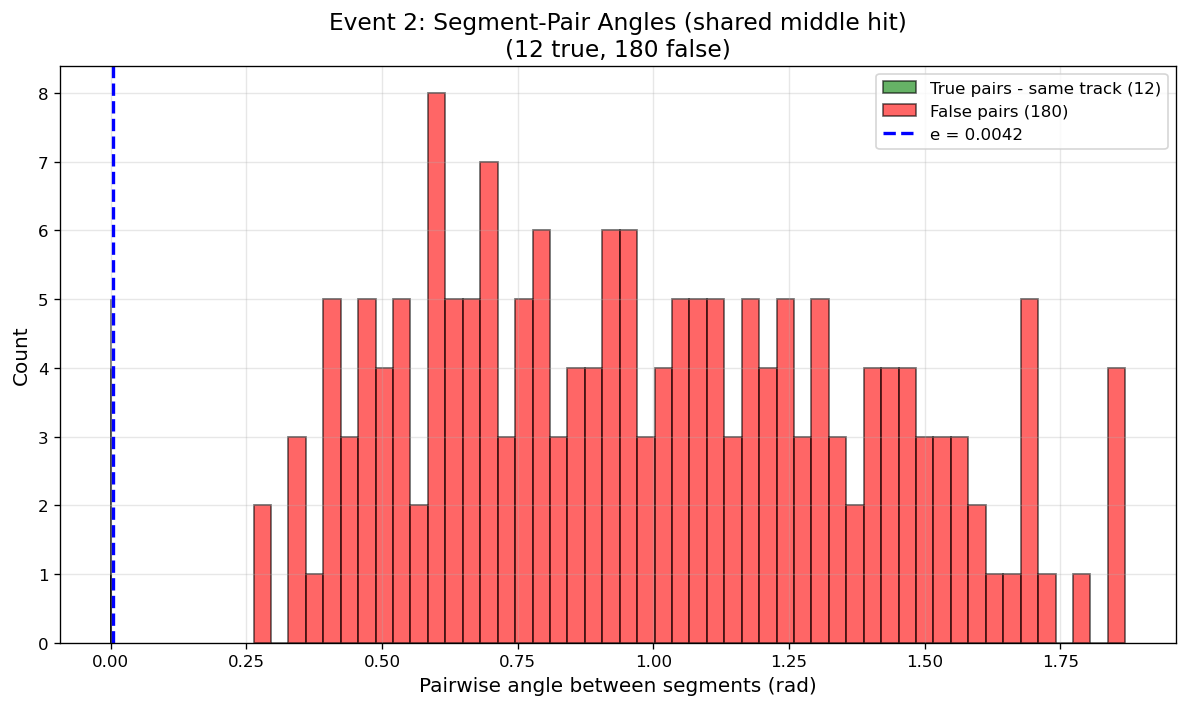

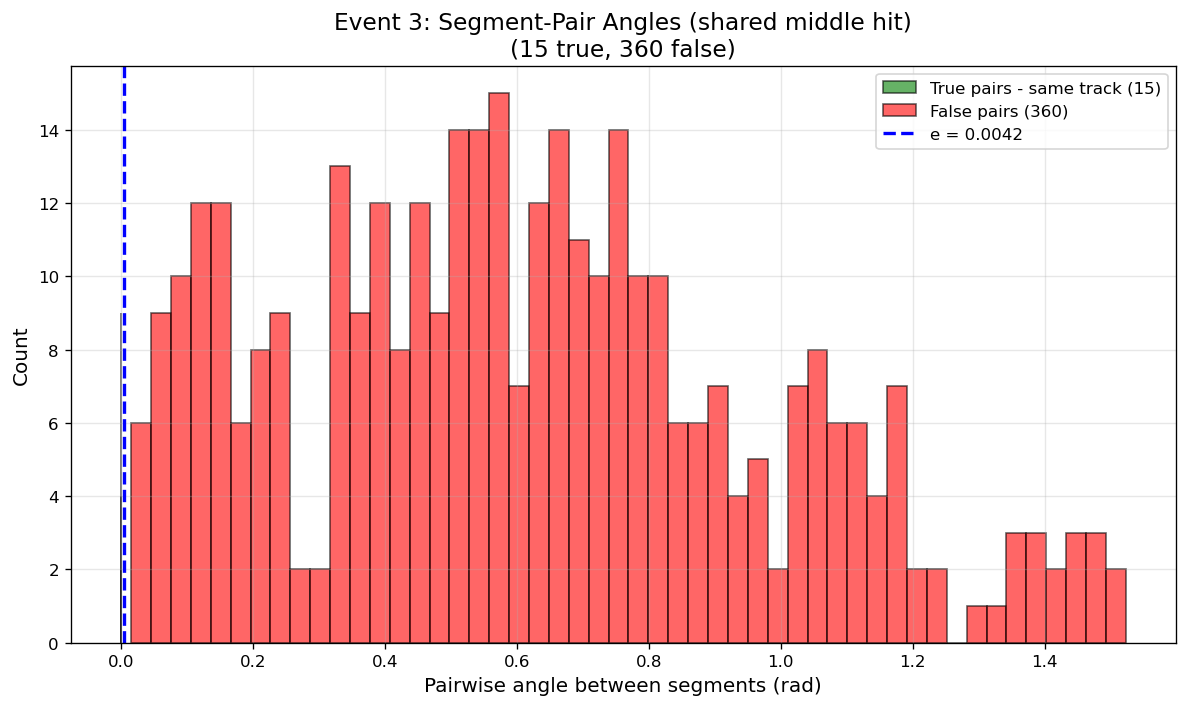

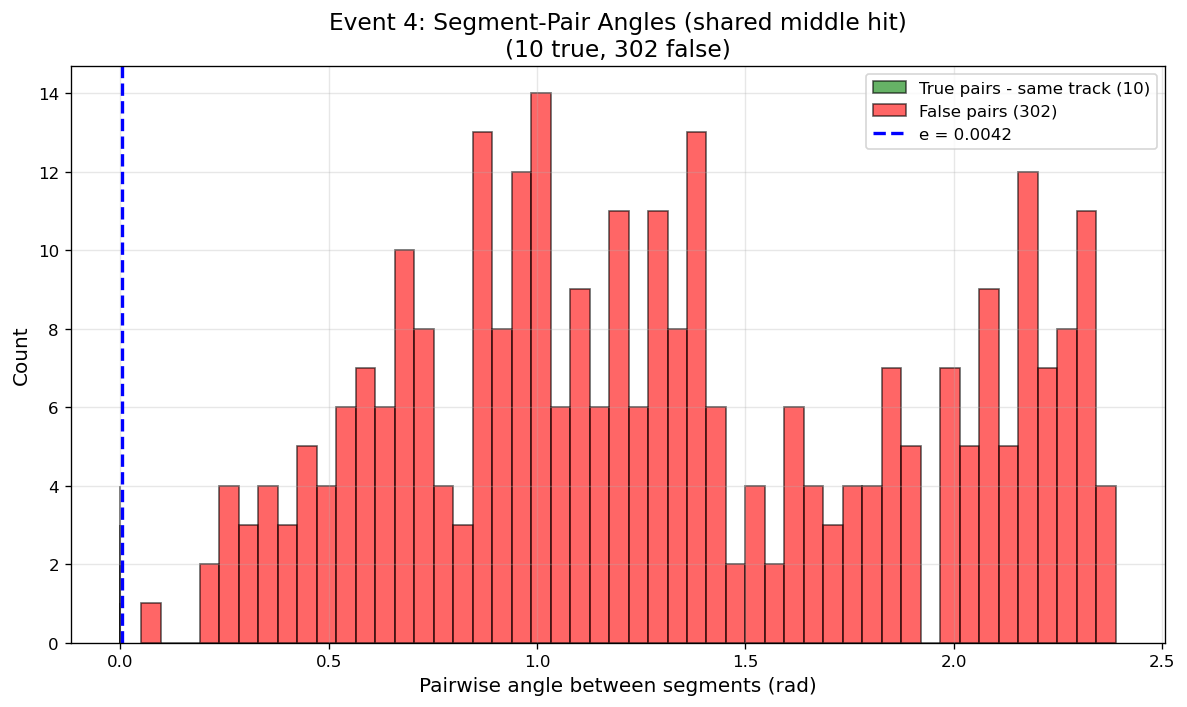

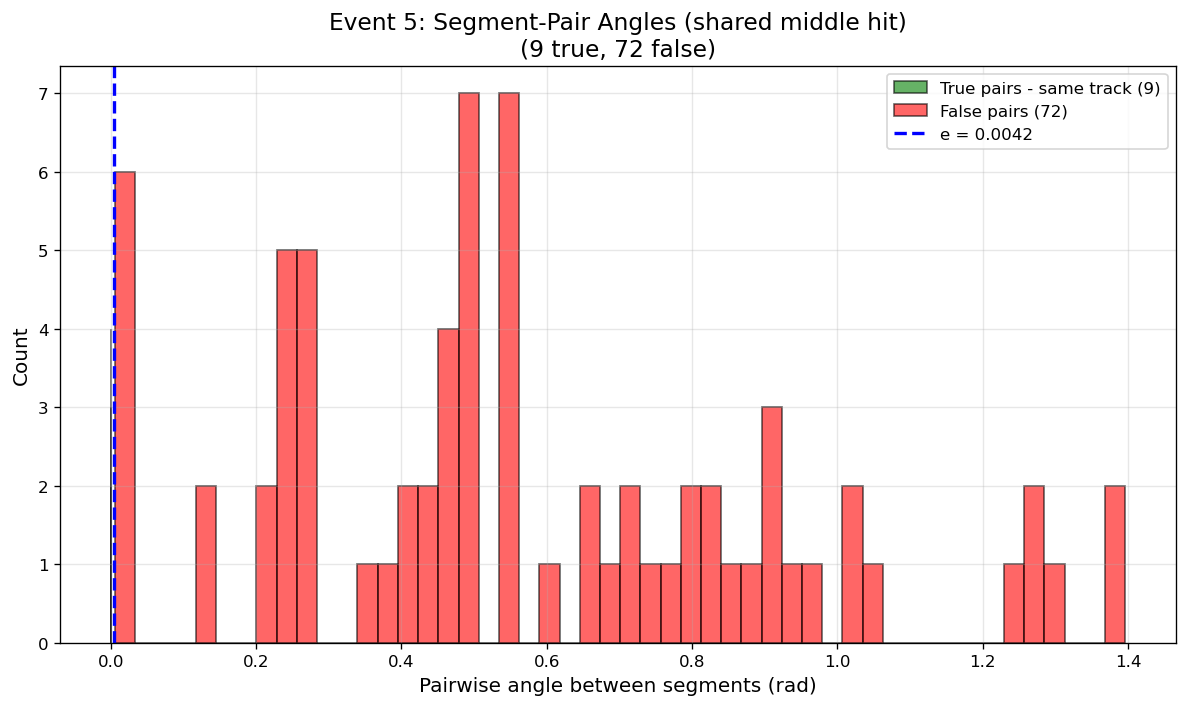

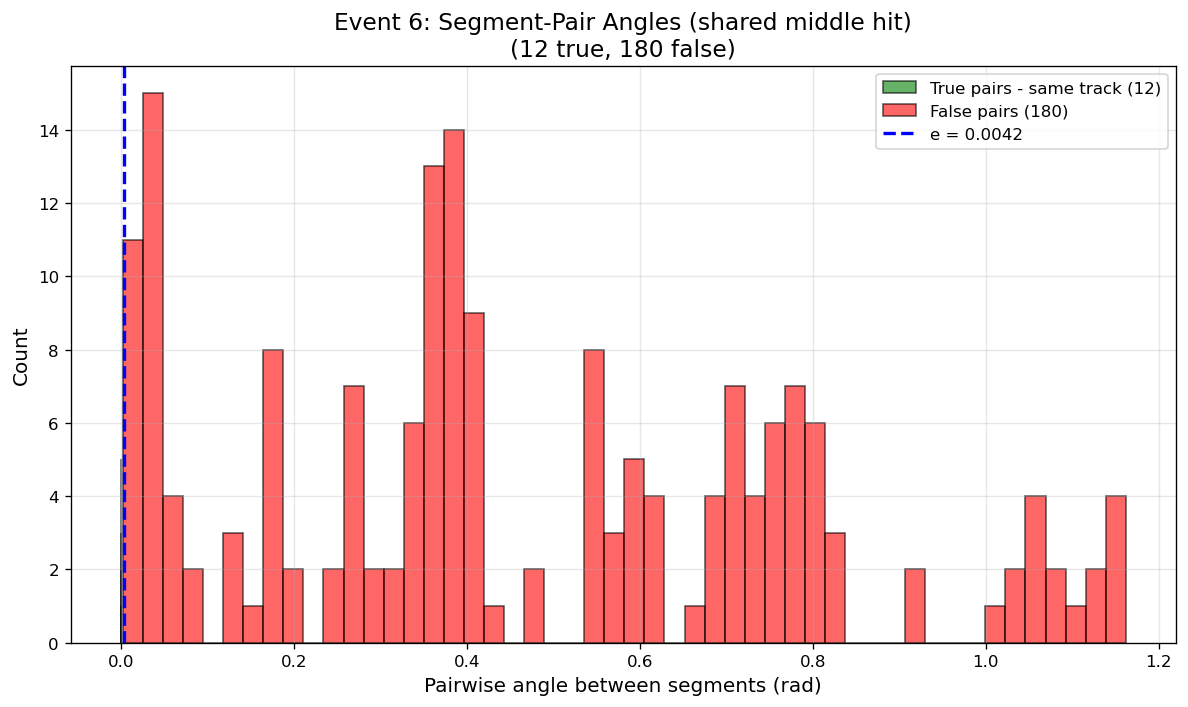

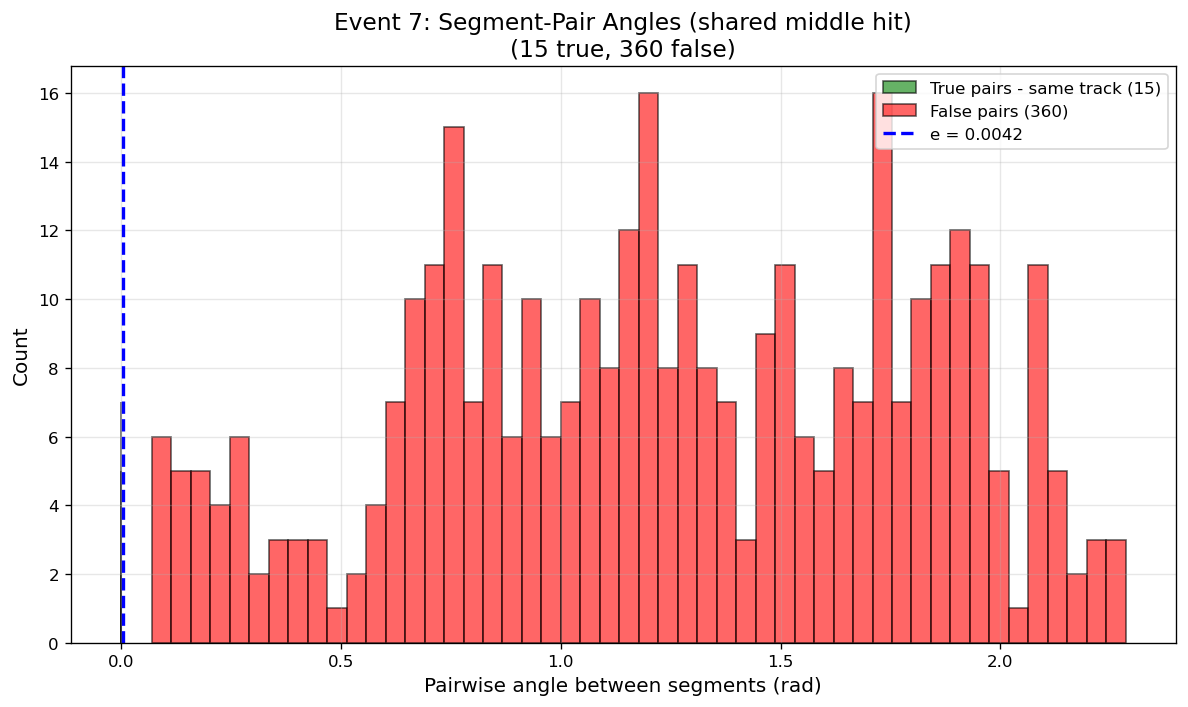

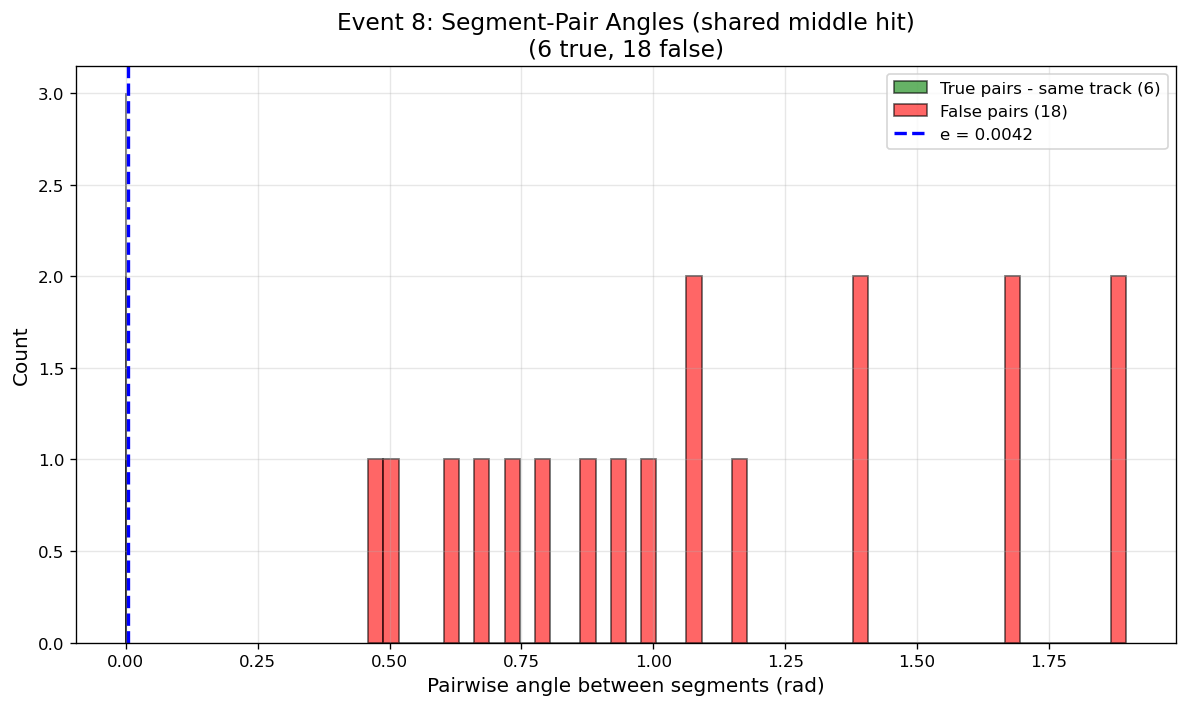

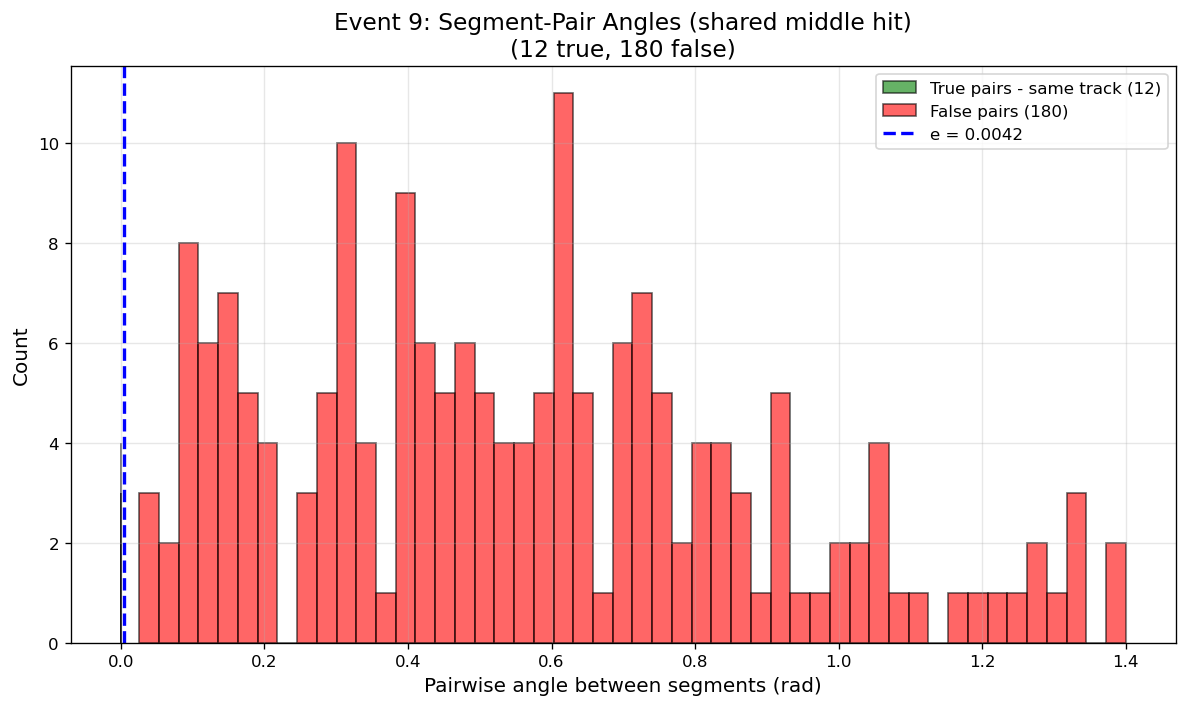

In [16]:
# ── Per-event: pairwise angles for segment pairs sharing a middle hit ─
# A "true pair" requires all 3 hits (a, mid, c) on the SAME track.

for ed in events_data:
    event_id = ed['event_id']
    event = ed['event']
    hits_dict = {hit.hit_id: hit for hit in event.hits}

    # Build true segment set
    true_seg_set = set()
    for trk in event.tracks:
        hids = trk.hit_ids
        for j in range(len(hids) - 1):
            true_seg_set.add((hids[j], hids[j + 1]))

    # Group hits by module
    hits_by_module = {}
    for h in event.hits:
        hits_by_module.setdefault(h.module_id, []).append(h)
    sorted_mod_ids = sorted(hits_by_module.keys())

    true_angles = []
    false_angles = []

    # For each middle module, pair incoming and outgoing segments
    for mi in range(1, len(sorted_mod_ids) - 1):
        mod_prev = sorted_mod_ids[mi - 1]
        mod_mid  = sorted_mod_ids[mi]
        mod_next = sorted_mod_ids[mi + 1]

        for h_mid in hits_by_module[mod_mid]:
            for h_prev in hits_by_module[mod_prev]:
                v1 = np.array([h_mid.x - h_prev.x, h_mid.y - h_prev.y, h_mid.z - h_prev.z])
                n1 = np.linalg.norm(v1)
                if n1 == 0: continue
                v1 /= n1
                seg_in_true = (h_prev.hit_id, h_mid.hit_id) in true_seg_set

                for h_next in hits_by_module[mod_next]:
                    v2 = np.array([h_next.x - h_mid.x, h_next.y - h_mid.y, h_next.z - h_mid.z])
                    n2 = np.linalg.norm(v2)
                    if n2 == 0: continue
                    v2 /= n2
                    seg_out_true = (h_mid.hit_id, h_next.hit_id) in true_seg_set

                    angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

                    # True pair: both segments true AND all 3 hits on same track
                    if (seg_in_true and seg_out_true and
                            h_prev.track_id is not None and
                            h_prev.track_id == h_mid.track_id == h_next.track_id):
                        true_angles.append(angle)
                    else:
                        false_angles.append(angle)

    fig, ax = plt.subplots(figsize=(10, 6))
    if true_angles:
        ax.hist(true_angles, bins=50, alpha=0.6, color='green',
                label=f'True pairs - same track ({len(true_angles)})', edgecolor='black')
    if false_angles:
        ax.hist(false_angles, bins=50, alpha=0.6, color='red',
                label=f'False pairs ({len(false_angles)})', edgecolor='black')
    ax.axvline(x=EPSILON, color='blue', ls='--', lw=2, label=f'e = {EPSILON:.4f}')
    ax.set_xlabel('Pairwise angle between segments (rad)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Event {event_id}: Segment-Pair Angles (shared middle hit)\n'
                 f'({len(true_angles)} true, {len(false_angles)} false)', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Combined: 106 true pairs (same track), 1,742 false pairs from 10 events


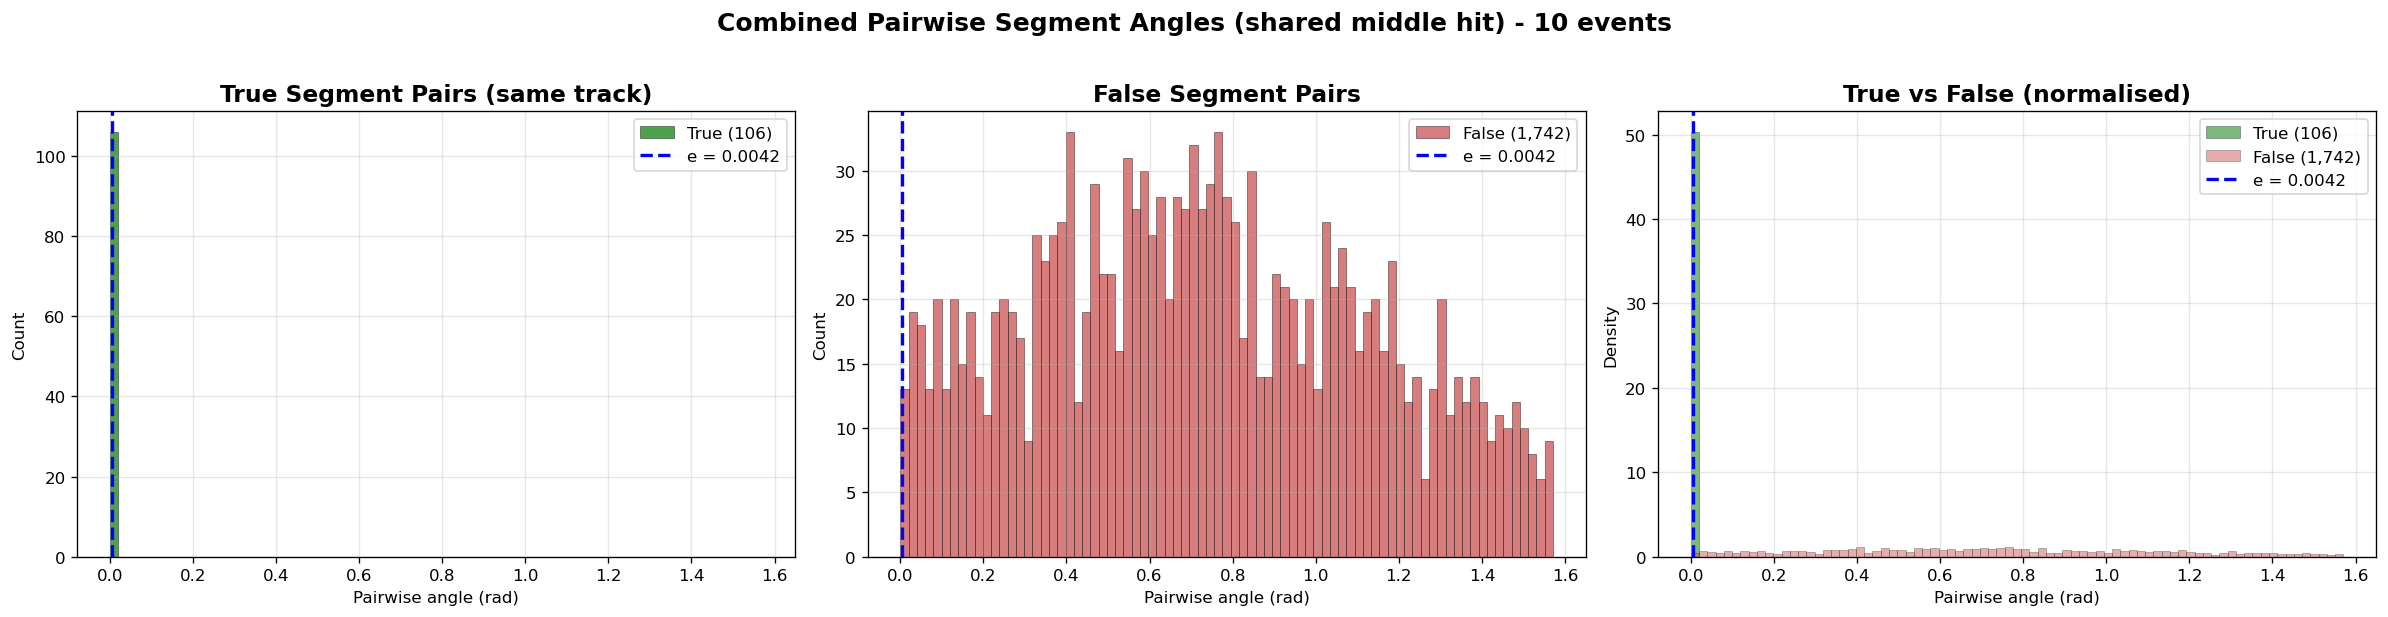

In [17]:
# ── Aggregate pairwise segment angles across ALL events ──────────
# Only segment pairs sharing a middle hit. "True" = all 3 hits same track.

combined_true_angles = []
combined_false_angles = []

for ed in events_data:
    event = ed['event']
    hits_dict = {hit.hit_id: hit for hit in event.hits}

    true_seg_set = set()
    for trk in event.tracks:
        hids = trk.hit_ids
        for j in range(len(hids) - 1):
            true_seg_set.add((hids[j], hids[j + 1]))

    hits_by_module = {}
    for h in event.hits:
        hits_by_module.setdefault(h.module_id, []).append(h)
    sorted_mod_ids = sorted(hits_by_module.keys())

    for mi in range(1, len(sorted_mod_ids) - 1):
        mod_prev = sorted_mod_ids[mi - 1]
        mod_mid  = sorted_mod_ids[mi]
        mod_next = sorted_mod_ids[mi + 1]

        for h_mid in hits_by_module[mod_mid]:
            for h_prev in hits_by_module[mod_prev]:
                v1 = np.array([h_mid.x - h_prev.x, h_mid.y - h_prev.y, h_mid.z - h_prev.z])
                n1 = np.linalg.norm(v1)
                if n1 == 0: continue
                v1 /= n1
                seg_in_true = (h_prev.hit_id, h_mid.hit_id) in true_seg_set

                for h_next in hits_by_module[mod_next]:
                    v2 = np.array([h_next.x - h_mid.x, h_next.y - h_mid.y, h_next.z - h_mid.z])
                    n2 = np.linalg.norm(v2)
                    if n2 == 0: continue
                    v2 /= n2
                    seg_out_true = (h_mid.hit_id, h_next.hit_id) in true_seg_set

                    angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

                    if (seg_in_true and seg_out_true and
                            h_prev.track_id is not None and
                            h_prev.track_id == h_mid.track_id == h_next.track_id):
                        combined_true_angles.append(angle)
                    else:
                        combined_false_angles.append(angle)

combined_true_angles = np.array(combined_true_angles)
combined_false_angles = np.array(combined_false_angles)
print(f"Combined: {len(combined_true_angles):,} true pairs (same track), "
      f"{len(combined_false_angles):,} false pairs from {len(events_data)} events")

# ── Plot ──
bins = np.linspace(0, np.pi/2, 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].hist(combined_true_angles, bins=bins, color='forestgreen', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'True ({len(combined_true_angles):,})')
axes[0].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'e = {EPSILON:.4f}')
axes[0].set_title('True Segment Pairs (same track)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pairwise angle (rad)')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=10); axes[0].grid(alpha=0.3)

axes[1].hist(combined_false_angles, bins=bins, color='indianred', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'False ({len(combined_false_angles):,})')
axes[1].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'e = {EPSILON:.4f}')
axes[1].set_title('False Segment Pairs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pairwise angle (rad)')
axes[1].set_ylabel('Count')
axes[1].legend(fontsize=10); axes[1].grid(alpha=0.3)

axes[2].hist(combined_true_angles, bins=bins, color='forestgreen', alpha=0.6,
             edgecolor='black', lw=0.3, density=True, label=f'True ({len(combined_true_angles):,})')
axes[2].hist(combined_false_angles, bins=bins, color='indianred', alpha=0.5,
             edgecolor='black', lw=0.3, density=True, label=f'False ({len(combined_false_angles):,})')
axes[2].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'e = {EPSILON:.4f}')
axes[2].set_title('True vs False (normalised)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Pairwise angle (rad)')
axes[2].set_ylabel('Density')
axes[2].legend(fontsize=10); axes[2].grid(alpha=0.3)

plt.suptitle(f'Combined Pairwise Segment Angles (shared middle hit) - {len(events_data)} events',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [18]:
# ── Generate many events x 50 tracks - PAIRWISE segment angles ───
# Angle between segment pairs sharing a middle hit.
# True pair = all 3 hits on the same track.

N_EVENTS = 100
N_TRACKS_STUDY = 50

all_true_angles = []
all_false_angles = []

for ev_i in range(N_EVENTS):
    for attempt in range(20):
        _, evt = generate_event(geo_clean, N_TRACKS_STUDY)
        if min(len(t.hit_ids) for t in evt.tracks) >= 3:
            break

    hits_dict = {h.hit_id: h for h in evt.hits}

    # True segment set for this event
    true_seg_set = set()
    for trk in evt.tracks:
        hids = trk.hit_ids
        for k in range(len(hids) - 1):
            true_seg_set.add((hids[k], hids[k + 1]))

    # Group hits by module
    hits_by_module = {}
    for h in evt.hits:
        hits_by_module.setdefault(h.module_id, []).append(h)
    sorted_mod_ids = sorted(hits_by_module.keys())

    # For each middle module, pair incoming + outgoing segments through each middle hit
    for mi in range(1, len(sorted_mod_ids) - 1):
        mod_prev = sorted_mod_ids[mi - 1]
        mod_mid  = sorted_mod_ids[mi]
        mod_next = sorted_mod_ids[mi + 1]

        for h_mid in hits_by_module[mod_mid]:
            for h_prev in hits_by_module[mod_prev]:
                v1 = np.array([h_mid.x - h_prev.x, h_mid.y - h_prev.y, h_mid.z - h_prev.z])
                n1 = np.linalg.norm(v1)
                if n1 == 0: continue
                v1 /= n1
                seg_in_true = (h_prev.hit_id, h_mid.hit_id) in true_seg_set

                for h_next in hits_by_module[mod_next]:
                    v2 = np.array([h_next.x - h_mid.x, h_next.y - h_mid.y, h_next.z - h_mid.z])
                    n2 = np.linalg.norm(v2)
                    if n2 == 0: continue
                    v2 /= n2
                    seg_out_true = (h_mid.hit_id, h_next.hit_id) in true_seg_set

                    angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

                    # True pair: both segments true + all 3 hits on SAME track
                    if (seg_in_true and seg_out_true and
                            h_prev.track_id is not None and
                            h_prev.track_id == h_mid.track_id == h_next.track_id):
                        all_true_angles.append(angle)
                    else:
                        all_false_angles.append(angle)

    if (ev_i + 1) % 20 == 0:
        print(f"  {ev_i + 1}/{N_EVENTS} events processed")

all_true_angles = np.array(all_true_angles)
all_false_angles = np.array(all_false_angles)
print(f"\nDone - {len(all_true_angles):,} true segment pairs, "
      f"{len(all_false_angles):,} false segment pairs "
      f"from {N_EVENTS} events x {N_TRACKS_STUDY} tracks")

  20/100 events processed
  40/100 events processed
  60/100 events processed
  80/100 events processed
  100/100 events processed

Done - 14,488 true segment pairs, 36,005,462 false segment pairs from 100 events x 50 tracks


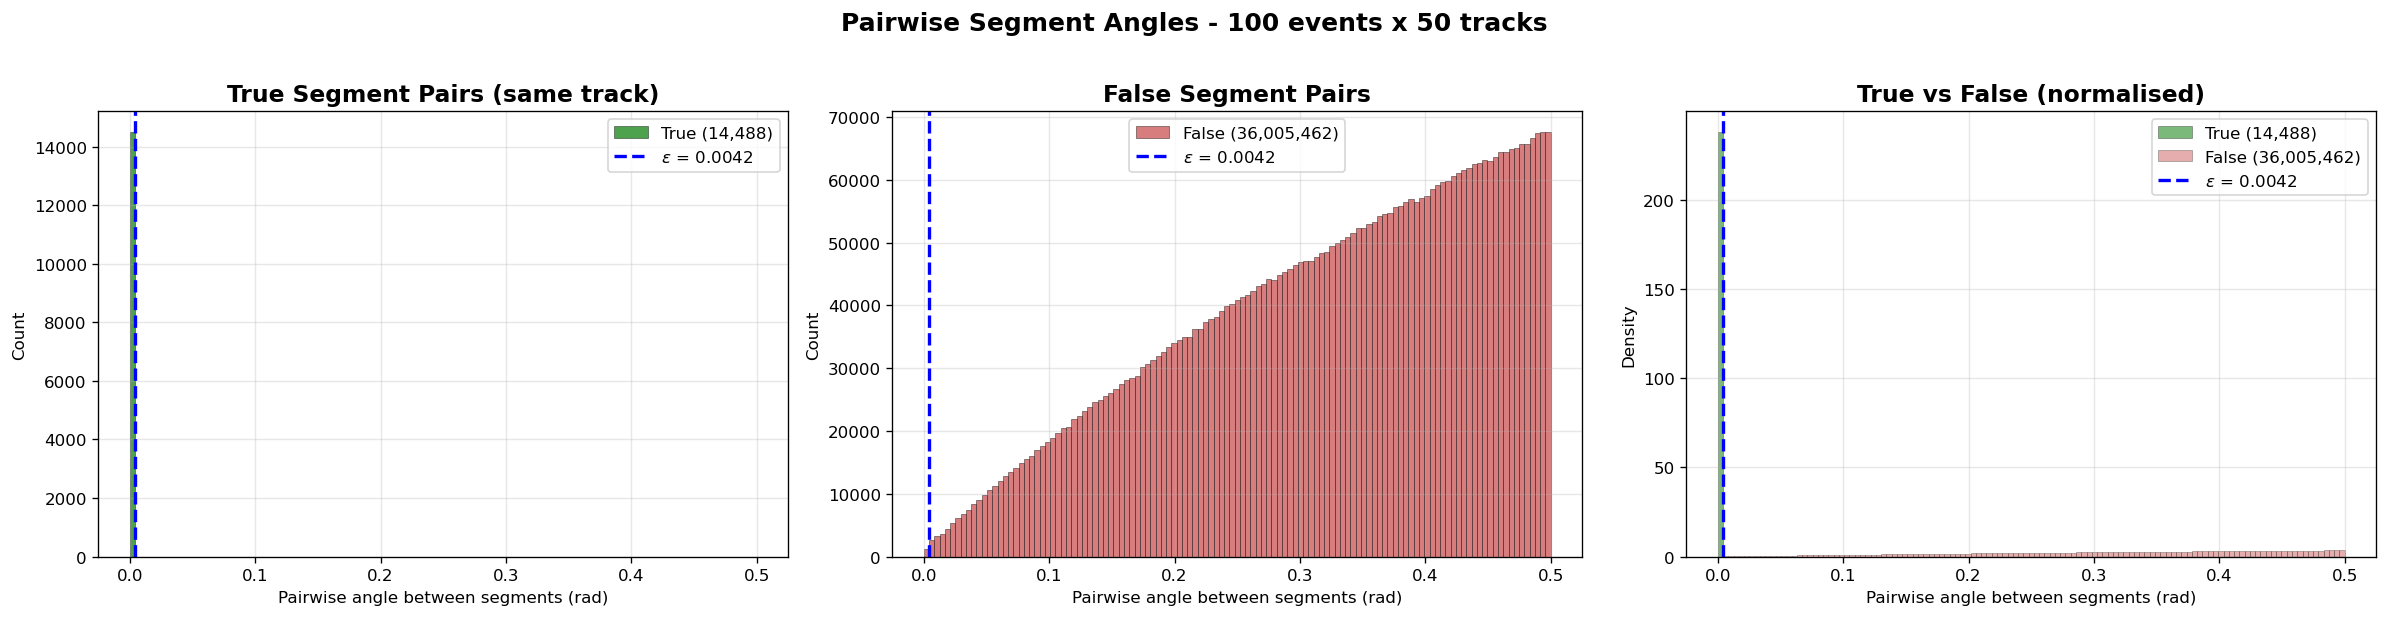

In [19]:
# ── Pairwise segment angle histograms with epsilon overlay ───────

bins = np.linspace(0, 0.5, 120)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].hist(all_true_angles, bins=bins, color='forestgreen', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'True ({len(all_true_angles):,})')
axes[0].axvline(EPSILON, color='blue', ls='--', lw=2,
                label=f'$\\varepsilon$ = {EPSILON:.4f}')
axes[0].set_title('True Segment Pairs (same track)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pairwise angle between segments (rad)')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=10); axes[0].grid(alpha=0.3)

axes[1].hist(all_false_angles, bins=bins, color='indianred', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'False ({len(all_false_angles):,})')
axes[1].axvline(EPSILON, color='blue', ls='--', lw=2,
                label=f'$\\varepsilon$ = {EPSILON:.4f}')
axes[1].set_title('False Segment Pairs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pairwise angle between segments (rad)')
axes[1].set_ylabel('Count')
axes[1].legend(fontsize=10); axes[1].grid(alpha=0.3)

axes[2].hist(all_true_angles, bins=bins, color='forestgreen', alpha=0.6,
             edgecolor='black', lw=0.3, density=True,
             label=f'True ({len(all_true_angles):,})')
axes[2].hist(all_false_angles, bins=bins, color='indianred', alpha=0.5,
             edgecolor='black', lw=0.3, density=True,
             label=f'False ({len(all_false_angles):,})')
axes[2].axvline(EPSILON, color='blue', ls='--', lw=2,
                label=f'$\\varepsilon$ = {EPSILON:.4f}')
axes[2].set_title('True vs False (normalised)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Pairwise angle between segments (rad)')
axes[2].set_ylabel('Density')
axes[2].legend(fontsize=10); axes[2].grid(alpha=0.3)

plt.suptitle(f'Pairwise Segment Angles - {N_EVENTS} events x {N_TRACKS_STUDY} tracks',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()